In [1]:
# Import Required Libraries

import tweepy
from tweepy import OAuthHandler
from tweepy import errors
import pandas as pd
import numpy as np
import datetime as dt
import time
import os
import json
import csv
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk import ngrams
from textblob import TextBlob

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud, ImageColorGenerator

!pip install nlp-id
from nlp_id.stopword import StopWord
stopword = StopWord()

from collections import defaultdict

from matplotlib import pyplot as plt
import seaborn as sns

!pip install deep-translator
from deep_translator import GoogleTranslator

#!pip install googletrans
#from googletrans import Translator

#!pip install google_trans_new
#from google_trans_new import google_translator

!pip install transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install xformers

!pip install sklearn
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 26.8 MB/s eta 0:00:00
  Created wheel for nlp-id: filename=nlp_id-0.1.15.0-py3-none-any.whl size=58153893 sha256=6d83becbb824dff7591c9f46ecbb951d975178709ce4e28c6d83bb9ba108529d
  Stored in directory: /root/.cache/pip/wheels/85/34/2a/deaf7b7896a1eed336b874e1a7732588d40bb7bdc0a824e73e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=fe1da851fa19e23f9eb600e47cb6013a226be92b430f11dd61bd7f001ba0e447
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built nlp-id wget
  Attempting uninstall: pytest
    Found existing installation: pytest 7.2.2
    Uninstalling pytest-7.2.2:
      Successfully unins

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
consumer_key = '1tPHivs802TIlHzLhemxnLOUB'
consumer_secret = 'ZZhv0hBC5RFEDTQbV7GoEdQvBpW2bslLPQ9NzZQbUp2iW2E7Sj'
access_token = '79173576-hPmw2wcrxtGo0zr3Y5tpP2SeyRKP8gfATynJio6OQ'
access_token_secret = 'O6FNosdMOelSe5HPzUwguHD8vrOzMJGd4ARdIWFfZubGJ'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
df_tweets = pd.DataFrame()
text_query = 'kuliah'
count = 10000

try:
    # Creation of query method using appropriate parameters
    tweets = tweepy.Cursor(api.search_tweets,q=text_query).items(count)

    # Pulling information from tweets iterable object and adding relevant tweet information in our data frame
    for tweet in tweets:
        df_query_based_tweets = df_query_based_tweets.append(
                          {'created_at' : tweet._json['created_at'],
                                        'userid': tweet._json['id'],
                               'username': tweet.user._json['name'],
                                        'text': tweet._json['text'],
                                 'twitterid': tweet._json['id_str'],
      #                'retweet_count': tweet._json['retweet_count'],  #premium api
      #                    'reply_count': tweet._json['reply_count'],
      #                      'like_count': tweet._json['like_count'],
                     'Description': tweet.user._json['description'],
                           'Location': tweet.user._json['location'],
             'Followers Count': tweet.user._json['followers_count'],
                 'Friends Count': tweet.user._json['friends_count'],
               'Statuses Count': tweet.user._json['statuses_count'],
         'Profile Image Url': tweet.user._json['profile_image_url'],
                         }, ignore_index=True)
except BaseException as e:
    print('failed on_status,',str(e))
    time.sleep(3)

failed on_status, 'reply_count'


In [ ]:
num_needed = 10000
#startdate = dt.datetime(2023, 6, 7, 0, 0, 0)
tweet_list = [] # Lists to be added as columns( Tweets, usernames, and screen names) in our dataframe
user_list = []
screen_name_list = []
created_at_list = []
tw_id = [] #<-- ADDED THIS
last_id = -1 # ID of last tweet seen
while len(tweet_list) < num_needed:
    try:
        new_tweets = api.search_tweets(q = 'kuliah -filter:retweets', count = num_needed, max_id = str(last_id - 1), lang = 'id', tweet_mode = 'extended') #until:2023-07-07 # This is the criteria for collecting the tweets that I want. I want to make sure the results are as accurate as possible when making a final analysis.
    except tweepy.TweepyException as e:
        print("Error", e)
        break
    else:
        if not new_tweets:
            print("Could not find any more tweets!")
            break
        else:
            for tweet in new_tweets:

                # Fetching the screen name and username

                screen_name = tweet.author.screen_name
                user_name = tweet.author.name
                created_at = tweet.created_at

                tweet_text = tweet.full_text
                tweet_list.append(tweet_text)
                user_list.append(user_name)
                screen_name_list.append(screen_name)
                created_at_list.append(created_at)

                tw_id.append(tweet.id)  #<-- ADDED THIS
    last_id = min(tw_id)  #<-- ADDED THIS


df_query_based_tweets = pd.DataFrame({'Screen_name':screen_name_list,
                   'Username':user_list,
                   'Tweets':tweet_list,
                   'Created_at':created_at_list})
df_query_based_tweets = df_query_based_tweets.drop_duplicates()

In [ ]:
df_query_based_tweets.head()

,Screen_name,Username,Tweets,Created_at
0,AldoBarasa,Al,Nyatanya pendidikan ku harus berhenti di semes...,2023-07-10 08:42:39+00:00
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah tim...,2023-07-10 08:42:36+00:00
2,admorae_,Admorae,@zakien6 Ini serius gak sih? 😭\nTp adek ku kel...,2023-07-10 08:42:36+00:00
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa...,2023-07-10 08:42:30+00:00
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kulia...",2023-07-10 08:42:22+00:00


In [ ]:
df_query_based_tweets.shape

(10000, 4)

In [ ]:
df_query_based_tweets.to_csv('/content/drive/My Drive/twitter_scraping_kuliah.csv', sep=';', index=False)

In [ ]:
df_query_based_tweets = pd.read_csv('/content/drive/My Drive/twitter_scraping_kuliah.csv', sep=';', lineterminator='\n')

In [ ]:
# Rename columns name

df_tweets = df_query_based_tweets.rename(columns={'Screen_name':'screen_name','Username':'username','Tweets':'text','Created_at':'time_posted'})

#df_tweets = df_tweets[['created_at','userid','username','text','followers_count','friends_count','status_count']]

In [ ]:
df_tweets['time_posted'] = df_tweets['time_posted'].astype('datetime64[ns]')
#pd.to_datetime(df_tweets['time_posted'], format='%Y%m%d:%H:%M:%S.%z')

In [ ]:
print(df_tweets.dtypes)

screen_name            object
username               object
text                   object
time_posted    datetime64[ns]
dtype: object


In [ ]:
df_tweets.head()

,screen_name,username,text,time_posted
0,AldoBarasa,Al,Nyatanya pendidikan ku harus berhenti di semes...,2023-07-10 08:42:39
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah tim...,2023-07-10 08:42:36
2,admorae_,Admorae,@zakien6 Ini serius gak sih? 😭\nTp adek ku kel...,2023-07-10 08:42:36
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa...,2023-07-10 08:42:30
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kulia...",2023-07-10 08:42:22


In [ ]:
df_tweets.shape

(10000, 4)

In [ ]:
# Derive date and time variables from time_posted variable

df_tweets['date'] = df_tweets['time_posted'].dt.date

df_tweets['time'] = df_tweets['time_posted'].dt.round('H')
df_tweets['time'] = df_tweets['time'].dt.time

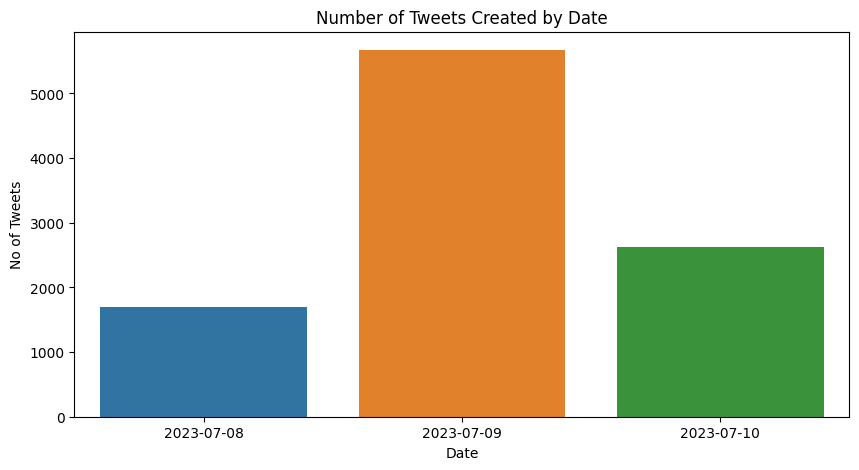

In [ ]:
# Visualize number of tweets by date posted

x_date = df_tweets['date'].value_counts().sort_index().index
y_date = df_tweets['date'].value_counts().sort_index()

s1 = sns.barplot(data = df_tweets, x = x_date, y = y_date)
s1.set_title('Number of Tweets Created by Date', fontsize = 12)
s1.set_xlabel('Date')
s1.set_ylabel('No of Tweets')
fig = plt.gcf()
fig.set_size_inches([10,5])
plt.show()

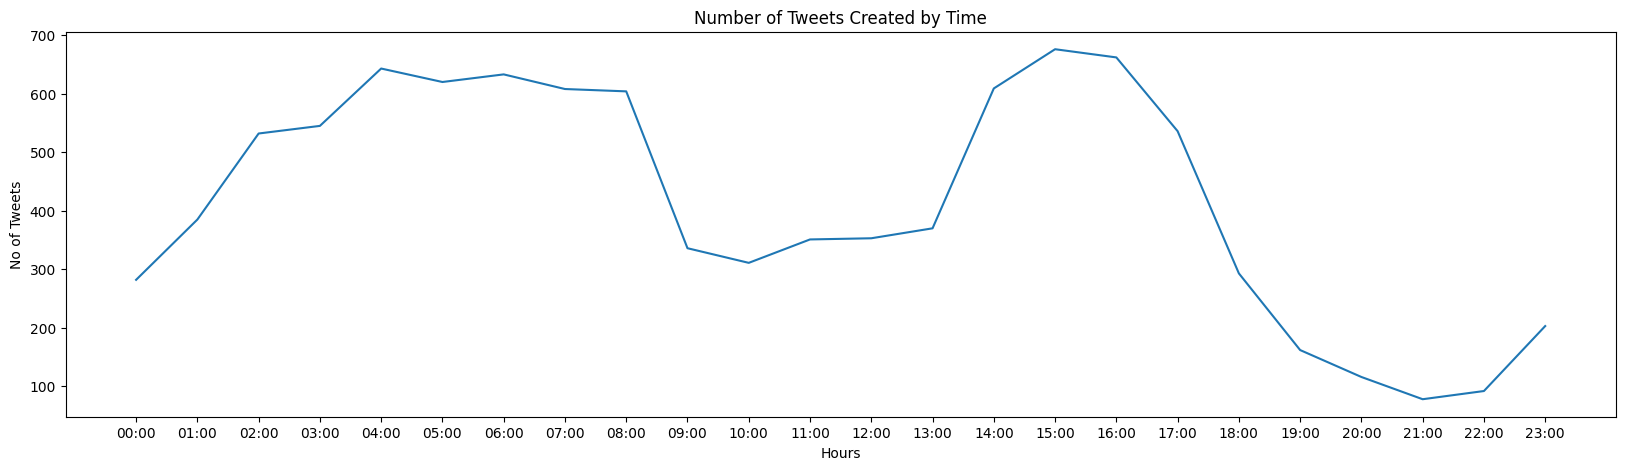

In [ ]:
# Visualize number of tweets by time posted

tweets_time = df_tweets['time'].value_counts().sort_index()
tweets_time = pd.DataFrame(tweets_time)
tweets_time = tweets_time.reset_index()
tweets_time = tweets_time.rename(columns={'index':'hours','time':'count'})
tweets_time['hours'] = tweets_time['hours'].astype(str)
tweets_time['hours'] = tweets_time['hours'].str[:5]

#fig, ax = plt.subplots(figsize = (12, 4))
s2 = sns.lineplot(data = tweets_time, x = 'hours', y = 'count')
s2.set_title('Number of Tweets Created by Time', fontsize = 12)
s2.set_xlabel('Hours')
s2.set_ylabel('No of Tweets')
fig = plt.gcf()
fig.set_size_inches([20,5])
plt.show()

In [ ]:
# Data Preprocessing

# define function text cleaning
def text_clean(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def text_lowercase(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def remove_emoji(text): # Remove emoji
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# apply text cleaning
df_tweets['text_cleaned'] = df_tweets['text'].apply(text_clean)
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].apply(text_lowercase)
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].apply(lambda emoji: remove_emoji(emoji))

In [34]:
slang_dict = json.load(open('/content/drive/My Drive/combined_slang_words.txt'))

In [37]:
print(list(slang_dict)[-1])
print(slang_dict[list(slang_dict)[-1]])

kulh
kuliah


In [36]:
slang_words={'kulh': 'kuliah'}
slang_dict.update(slang_words)

text_cleaned_slang = []
for text in df_tweets['text_cleaned']:
  wordlist = TextBlob(text).words
  for k,v in enumerate(wordlist):
    if v in slang_dict.keys():
      wordlist[k] = slang_dict[v]
  text_cleaned_slang.append(' '.join(wordlist))

In [38]:
#df_tweets['text_cleaned_slang'] = text_cleaned_slang
#cancel slang since genereate no sense text from text_cleaned

In [39]:
df_tweets.head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity,polarity_indobert,polarity_score_indobert,text_cleaned_slang
0,AldoBarasa,Al,"Nyatanya pendidikan ku harus berhenti di semester 2 ini,\nMau nangis y Allah, tapi gpp lah nanti klo ad uang bisa kuliah sendiri aj 🥺",2023-07-10 08:42:39,2023-07-10,09:00:00,nyatanya pendidikan ku harus berhenti di semester ini mau nangis y allah tapi gpp lah nanti klo ad uang bisa kuliah sendiri aj,"['didik', 'ku', 'henti', 'semester', 'nang', 'y', 'allah', 'gpp', 'klo', 'ad', 'uang', 'kuliah', 'aj']",-5,negative,negative,0.984239,nyatanya pendidikan ku harus berhenti di semester ini mau menangis ya allah tapi tidak apa-apa lah nanti kalau ada uang bisa kuliah sendiri saja
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah timbang dari kampus rumah dulu klo liat dari gmaps\n\nTapi ongkos PP kampus rumah tuh lebih banyak daripada PP kantor rumah🫠\n\nPantesan jaman kuliah gw ngerasa seringnya ga punya duit. Habis di ongkos sksk,2023-07-10 08:42:36,2023-07-10,09:00:00,perasaan masih jauhan kantor gw dari rumah timbang dari kampus rumah dulu klo liat dari gmaps tapi ongkos pp kampus rumah tuh lebih banyak daripada pp kantor rumah pantesan jaman kuliah gw ngerasa seringnya ga punya duit habis di ongkos sksk,"['asa', 'jauh', 'kantor', 'gw', 'rumah', 'timbang', 'kampus', 'rumah', 'klo', 'liat', 'gmaps', 'ongkos', 'pp', 'kampus', 'rumah', 'tuh', 'pp', 'kantor', 'rumah', 'pantesan', 'jaman', 'kuliah', 'gw', 'ngerasa', 'ga', 'duit', 'habis', 'ongkos', 'sksk']",3,positive,negative,0.858025,perasaan masih jauhan kantor saya dari rumah timbang dari kampus rumah dulu kalau lihat dari gmaps tapi ongkos pulang pergi kampus rumah tuh lebih banyak daripada pulang pergi kantor rumah pantesan jaman kuliah saya ngerasa seringnya ga punya duit habis di ongkos sksk
2,admorae_,Admorae,"@zakien6 Ini serius gak sih? 😭\nTp adek ku kelas 2 SMP juga mikirnya udah mau lanjut kuliah ke luar negeri aja, kerja keluar negeri, soalnya cari kerja di Indo susah dll. Apa remaja saat ini emang udah mikir jauh banget kayak gitu??? 😶",2023-07-10 08:42:36,2023-07-10,09:00:00,ini serius gak sih tp adek ku kelas smp juga mikirnya udah mau lanjut kuliah ke luar negeri aja kerja keluar negeri soalnya cari kerja di indo susah dll apa remaja saat ini emang udah mikir jauh banget kayak gitu,"['gak', 'tp', 'adek', 'ku', 'kelas', 'smp', 'mikirnya', 'kuliah', 'negeri', 'kerja', 'negeri', 'cari', 'kerja', 'indo', 'susah', 'remaja', 'mikir', 'kayak']",-15,negative,negative,0.993267,ini serius gak sih tapi adek ku kelas smp juga mikirnya sudah mau lanjut kuliah ke luar negeri saja kerja keluar negeri soalnya cari kerja di indo susah dan lain-lain apa remaja saat ini emang sudah mikir jauh banget kayak gitu
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu tanam itu yg lu tuai NIKMATIN BUAH DARI KESALAHAN LO percaya ga percaya kalo dariawal udh ga jujur sampai akhir juga bakalan banyak problem yg nimpa kamu. baru segini aja udh curang gmn masuk kuliah lu joki? https://t.co/0C0XOTjJU3,2023-07-10 08:42:30,2023-07-10,09:00:00,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu tanam itu yg lu tuai nikmatin buah dari kesalahan lo percaya ga percaya kalo dariawal udh ga jujur sampai akhir juga bakalan banyak problem yg nimpa kamu baru segini aja udh curang gmn masuk kuliah lu joki,"['wlwkwlwlwlwlwlw', 'lu', 'tanam', 'lu', 'tuai', 'nikmatin', 'buah', 'salah', 'lo', 'percaya', 'ga', 'percaya', 'kalo', 'dariawal', 'udh', 'ga', 'jujur', 'problem', 'nimpa', 'gin', 'udh', 'curang', 'gmn', 'masuk', 'kuliah', 'lu', 'joki']",-11,negative,negative,0.996839,wlwkwlwlwlwlwlw waduh waduh waduh apa yang kamu tanam itu yang kamu tuai nikmatin buah dari kesalahan kamu percaya ga percaya kalau dariawal udh ga jujur sampai akhir juga akan banyak masalah yang nimpa kamu baru segini saja udh curang gmn masuk kuliah kamu joki
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kuliah, beuh, meleda

In [ ]:
# define function tokenizing, filter stopwords, stemming

def text_tokenize(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def text_filter(text): # Remove stopwords in a text from nltk library
    list_stopwords = set(stopwords.words('indonesian'))
    text_filtered = []
    for txt in text:
        if txt not in list_stopwords:
            text_filtered.append(txt)
    text = text_filtered
    return text

def text_filter2(text): # Remove stopwords in a text from nlp-id library
    list_stopwords2 = stopword.get_stopword()
    text_filtered2 = []
    for txt in text:
        if txt not in list_stopwords2:
            text_filtered2.append(txt)
    text = text_filtered2
    return text

def text_stemming(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

In [ ]:
# apply text tokenizing, remove stopwords, stemming

start_time = time.time()
df_tweets['text_preprocessed'] = df_tweets['text_cleaned'].apply(text_tokenize)
df_tweets['text_preprocessed'] = df_tweets['text_preprocessed'].apply(text_filter)
df_tweets['text_preprocessed'] = df_tweets['text_preprocessed'].apply(text_filter2)
df_tweets['text_preprocessed'] = df_tweets['text_preprocessed'].apply(text_stemming)
print("Run time %s seconds" % (time.time() - start_time))

Run time 9240.651727199554 seconds


In [ ]:
df_tweets.to_csv('/content/drive/My Drive/twitter_scraping_kuliah_prepro.csv', sep=';', index=False)

In [ ]:
df_tweets = pd.read_csv('/content/drive/My Drive/twitter_scraping_kuliah_prepro.csv', sep=';', lineterminator='\n')

In [ ]:
df_tweets[['text','text_cleaned','text_preprocessed']].head(10)

,text,text_cleaned,text_preprocessed
0,Nyatanya pendidikan ku harus berhenti di semes...,nyatanya pendidikan ku harus berhenti di semes...,"[didik, ku, henti, semester, nang, y, allah, g..."
1,Perasaan masih jauhan kantor gw dari rumah tim...,perasaan masih jauhan kantor gw dari rumah tim...,"[asa, jauh, kantor, gw, rumah, timbang, kampus..."
2,@zakien6 Ini serius gak sih? 😭\nTp adek ku kel...,ini serius gak sih tp adek ku kelas smp juga...,"[gak, tp, adek, ku, kelas, smp, mikirnya, kuli..."
3,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa...,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu t...,"[wlwkwlwlwlwlwlw, lu, tanam, lu, tuai, nikmati..."
4,"when u ngerantau sendirian, kerja sambil kulia...",when u ngerantau sendirian kerja sambil kuliah...,"[when, u, ngerantau, kerja, kuliah, beuh, ledak]"
5,"@vckyrakus Aku pernah pas kuliah dulu, belakan...",aku pernah pas kuliah dulu belakang kamar kos ...,"[kuliah, kamar, kos, lahan, kosong, bangun, ja..."
6,"Kisah dahulu\n""Kuliah jurusan apa?""\n""Fisioter...",kisah dahulu kuliah jurusan apa fisioterapi ja...,"[kisah, kuliah, jurus, fisioterapi, tulang, pi..."
7,@yummeeraviolee @babufess yaaahhh😭😭😭😭😭😭 mangaa...,yaaahhh mangaattt kuliah sayyyy,"[yaaahhh, mangaattt, kuliah, sayyyy]"
8,@nyfahrochi @graciyya @tanyakanrl Mjb sebenern...,mjb sebenernya seri a itu nggak jelek sih menu...,"[mjb, seri, a, nggak, jelek, turut, pake, sams..."
9,"@tanyarlfes Pacarku nonmus pake sarung, Trs ju...",pacarku nonmus pake sarung trs juga kuliah di ...,"[pacar, nonmus, pake, sarung, trs, kuliah, uni..."


In [ ]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# load & create dictionary for positive lexicon

lexicon_positive = {}

with open(os.path.join('/content/drive/MyDrive', 'lexicon_positive.tsv')) as tsv_file:
    reader = csv.reader(tsv_file, delimiter='\t')
    next(reader)
    for word, weight in reader:
        lexicon_positive[word] = int(weight)

# load & create dictionary for negative lexicon

lexicon_negative = {}

with open(os.path.join('/content/drive/MyDrive', 'lexicon_negative.tsv')) as tsv_file:
    reader = csv.reader(tsv_file, delimiter='\t')
    next(reader)
    for word, weight in reader:
        lexicon_negative[word] = int(weight)

In [ ]:
lexicon_negative

{'putus tali gantung': -2,
 'gelebah': -2,
 'gobar hati': -2,
 'tersentuh (perasaan)': -1,
 'isak': -5,
 'larat hati': -3,
 'nelangsa': -3,
 'remuk redam': -5,
 'tidak segan': -2,
 'gemar': -1,
 'tak segan': -1,
 'sesal': -4,
 'pengen': -2,
 'penghayatan': -2,
 'absorpsi': -1,
 'linu': -4,
 'salah benang': -1,
 'sakit': -5,
 'lara': -5,
 'zuhud': -1,
 'mencederai': -4,
 'mengingkari': -4,
 'maaf': -3,
 'mengkhianat': -4,
 'mencelakai': -5,
 'mulu': -1,
 'ngga': -2,
 'borong': -1,
 'lever': -2,
 'kasian': -3,
 'gamau': -4,
 'doang': -1,
 'pulas': -1,
 'abis': -2,
 'coba': -1,
 'kangen': -3,
 'kalau': -1,
 'maunya': -1,
 'seandainya': -1,
 'marilah': -1,
 'bener': -1,
 'yaudah': -4,
 'nggak': -3,
 'gatau': -1,
 'apaan': -4,
 'ngakak': -2,
 'atuh': -1,
 'sekali': -1,
 'menarik hati': -1,
 'cedayam': -2,
 'kece': -3,
 'termakan': -1,
 'belom': -1,
 'malem': -1,
 'mencekau': -2,
 'menduga': -1,
 'menyuarakan': -1,
 'memprediksi': -1,
 'membunyikan': -1,
 'menerka': -1,
 'menaksir': -1,
 'me

In [ ]:
# function to determine sentiment score polarity of tweets

def sentiment_analysis_lexicon_indonesia(text):
    #initialize score and check for word in text
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    #initialize polarity and determine labeling
    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    #return the value as score and polarity
    return score, polarity

In [ ]:
# apply tweets sentiment polarity based on dictionary of lexicon indonesia

start_time = time.time()
results = df_tweets['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_tweets['polarity_score'] = results[0]
df_tweets['polarity'] = results[1]
print("Run time %s seconds" % (time.time() - start_time))
print(df_tweets['polarity'].value_counts())

Run time 0.08902859687805176 seconds
negative    6920
positive    2552
neutral      528
Name: polarity, dtype: int64


In [ ]:
df_tweets.head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity
0,AldoBarasa,Al,Nyatanya pendidikan ku harus berhenti di semes...,2023-07-10 08:42:39,2023-07-10,09:00:00,nyatanya pendidikan ku harus berhenti di semes...,"[didik, ku, henti, semester, nang, y, allah, g...",-5,negative
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah tim...,2023-07-10 08:42:36,2023-07-10,09:00:00,perasaan masih jauhan kantor gw dari rumah tim...,"[asa, jauh, kantor, gw, rumah, timbang, kampus...",3,positive
2,admorae_,Admorae,@zakien6 Ini serius gak sih? 😭\nTp adek ku kel...,2023-07-10 08:42:36,2023-07-10,09:00:00,ini serius gak sih tp adek ku kelas smp juga...,"[gak, tp, adek, ku, kelas, smp, mikirnya, kuli...",-15,negative
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa...,2023-07-10 08:42:30,2023-07-10,09:00:00,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu t...,"[wlwkwlwlwlwlwlw, lu, tanam, lu, tuai, nikmati...",-11,negative
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kulia...",2023-07-10 08:42:22,2023-07-10,09:00:00,when u ngerantau sendirian kerja sambil kuliah...,"[when, u, ngerantau, kerja, kuliah, beuh, ledak]",-3,negative


In [ ]:
sentiment_dist = df_tweets['polarity'].value_counts()
sentiment_dist = pd.DataFrame(sentiment_dist)
sentiment_dist = sentiment_dist.reset_index()
sentiment_dist.head()

,index,polarity
0,negative,6920
1,positive,2552
2,neutral,528


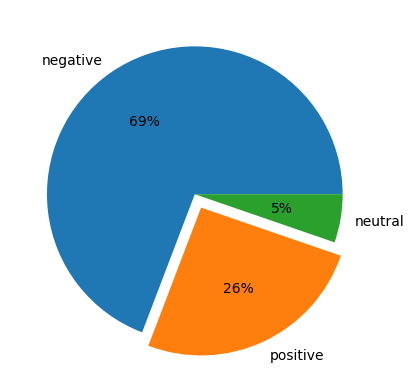

In [ ]:
# Tweets sentiment distribution

plt.pie(sentiment_dist['polarity'], labels=sentiment_dist['index'],
        explode=[0, 0.1, 0], autopct='%.0f%%')
plt.show()

In [ ]:
# Show top 10 positive tweets

pd.set_option('display.max_colwidth', None)
positive_tweets = df_tweets[df_tweets['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_cleaned', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_cleaned,polarity_score,polarity
1,nline butuh dana pinjaman proses mudah amp cepat khusus online butuh dana dana biaya sekolah dana biaya kuliah dana renovasi rumah dana modal usaha dana sampingan silahkan hubungi atau chat klik link whatsapp amanah amp terpercaya,34,positive
2,butuh dana proses mudah amp cepat khusus online butuh dana dana biaya dana biaya dana dana dana silahkan hubungi atau chat klik link whatsapp amanah amp terpercaya,33,positive
3,hai kak thankyou udah mau berbagi happy birthday ya kak semoga sehat sllu mudah rezeki lancar dan sllu dimudahkan segala urusan kakak semoga tahun ini kuliah kakak lancar sampai selesai aamiin god bless u goodluck wish me luck‍,33,positive
4,dari awal kuliah mahasiswa udh diajarin cara penilaian buat nilai siswa ditegesin banget cara nilainya harus proses yg dinilai hasil itu dinilai belakangan tapi baru kali ini liat dosen ngadain penilaian kaya org tolol gini,29,positive
5,yg paling penting dr kuliah itu apa gelar kah selempang dgn tulisan s kah kl ada manusia mandang gelar km anggap allah apa slm ini allah mandang manusia dr apa ikhtiardoahati hablumminallah hablumminannas allah maha baik jd lah manusia yg baik thd sluruh makhluknya,29,positive
6,happy birthday kak semoga kuliah yang emang kadang bikin stresseu ini bisa dilalui dengan happy happy ya semoga nanti hasil akhirnya memuaskan,28,positive
7,semoga dapet temen sekelompok yang sefrekuensi asik baik bisa diajak kerjasama saling support dalam keadaan apapun saling memahami dan mengingatkan bisa jadi rumah satu sama lain pokoknya semua yang baik” dan semoga kuliah kami lancar berkah sampe lulus aamiin ya allah,28,positive
8,seperti di tempat saya kuliah meski ujian ketika kuliah berat tapi saat ujian kompetensi saat itu kami langsung lulus sekali ujian kompetensi meski sekarang masih terdengar berita ratusan ribu mahasiswa perguruan tinggi kesehatan di indonesia ga lulus ujian kompetensi,28,positive
9,haii kakk happy birthday to you semogaa panjang umur sehat selalu dan bahagia selalu semoga rezekinya berlimpah dan lancarsemoga selalu di berikan kelancaran kuliah nya tahun inii aamiin,28,positive
10,enci saya suka masjid masjid terbaik di bdg itu masjid salman saya kuliah s jd rohis boy di sini dan masjid al lathiif yg darinya dakwah islam membludak dg pemuda hijrah i’m all for masjid tp alangkah baiknya kalo uang pajak dipakai utk maslahat umat yg saat ini mendesak,28,positive


In [ ]:
# Show top 10 negative tweets

negative_tweets = df_tweets[df_tweets['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_cleaned', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_cleaned,polarity_score,polarity
1,itu bukan tangisan terakhir yang el liat soalnya pangpang nangis mulu nangis pas nilainya jelek banget dan harus ngulang dua mata kuliah tpb nangis pas el dirawat karena typhoid nangis pas bonnie anjing di kosan el mati tapi pangpang cuma nangis depan el kok,-48,negative
2,info a info dari orang dalam info pihak² terkait info dari orang dalam info a info a info dari orang dalam info dari orang dalam info a info a info dari orang dalam info dari orang dalam info a beginian terus sampai upin ipin kuliah,-42,negative
3,selama kuliah tu kan memang jarang banget minum susu sekali minum susu terjadi badai internal waktu pandemi gue latih minum susu dikit tiap hari bisa minum susu lagi dong keknya mesin enzimnya dorman kemudian bangun kembali tsaaah…,-41,negative
4,ya pusing magang ya pusing laporan kas ya pusing pelayanan ya pusing pelayanan ya pusing keluarga abis kecelakaan ya pusing kuliah ya pusing kerjaan pusing kok semua jangan pada puter dong biar ga pusing,-40,negative
5,tb keinget pernah bayarin kuliah org semester trs orgnya ga niat kuliah emg goblok sih kayaknya trs saking gedegnya aku buang jas almamaternya di tempat sampah pdhl harusnya suruh pake aja ga si jasnya org dianya udh sampah najis kesel bgt dulu pernah segitunya,-38,negative
6,pagi pagi di todong kuliah lanjutin kak blablabla wkwkwk kalau gua egois mau kali dari kemarin gua udah egois ada satu prioritas yang harus gua cukupi sedih mah sedih gua tnggal refisi kalau sidang ya tinggal sidang tiap perjalanan selalu ada persimpangan bukan,-37,negative
7,sebenarnya tergantung standar parahnya di sini sih karena standar parah versi anak kota kota besar khususnya ibu kota dengan versi anak daerah itu jelas berbeda tapi aku sendiri bakal bilang kalau kamu pintar memilih dan menilai pergaulan kuliah ngga yang separah itu sih,-36,negative
8,anak tmn gw kelas sd udah bingung mau kuliah di jerman atw inggris krn kalo jadi ambil di jerman dia harus belajar bahasanya skrg anaknya naik kelas mutusin buat kuliah di jerman th depan udah pede banget krn ga pusing soal bahasa emak bapaknya yg pusing cari duit,-36,negative
9,sangking pusingnya mikirin problem yg ga ada abisnya denger ini sampe nangis berat bgt jadi anak cewe pertama pekerja kuliah juga pen nangis tapi di pelukan seungkwan miss u boo,-34,negative
10,tutor ngeluh cape pas kuliah dong aing samsek gapernah ngerasa cape pas kuliah padahal semester juga sama cuma beda kampus aja kok mereka bisa cape padahal pada ngekost sedangkan aku pp gacape tu cuma cape naek motor doang bukan cape kuliah,-34,negative


In [ ]:
# Function to group all positive/negative words based on polarity score

def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]

        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)

    return positive_words, negative_words

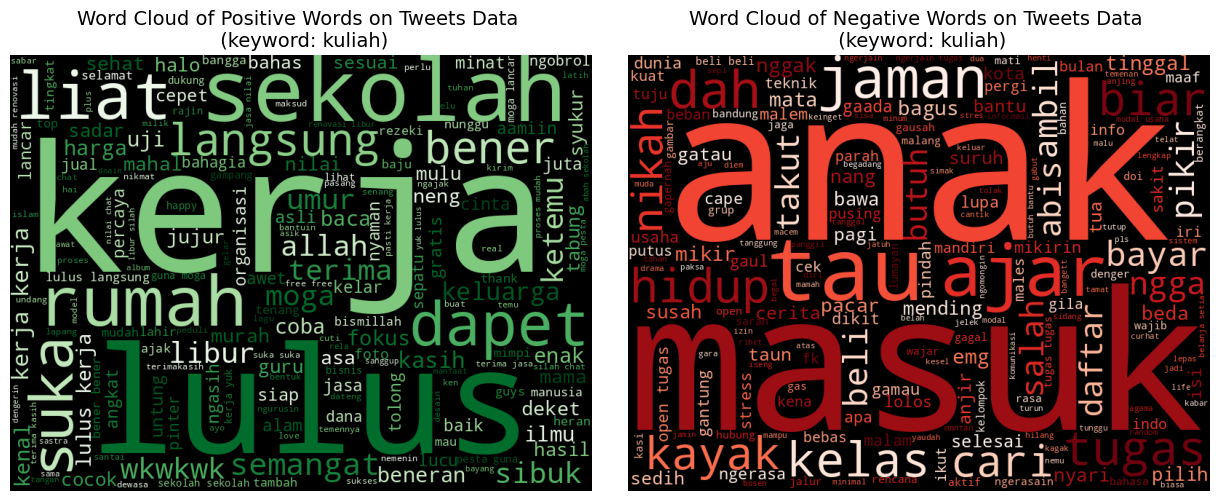

In [ ]:
# Visualize positive and negative word cloud

sentiment_words = df_tweets['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]
query_words={'kuliah'}

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(stopwords=query_words, width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (keyword: kuliah)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(stopwords=query_words, width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (keyword: kuliah)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

In [ ]:
# Show top 20 negative tweets with word anak

substring = 'anak'
negative_df_tweets = df_tweets[df_tweets['polarity'] == 'negative']
negative_df_tweets = negative_df_tweets[['text_cleaned', 'polarity_score', 'polarity']]
anak_tweets = negative_df_tweets[negative_df_tweets.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
anak_tweets[0:20]

,text_cleaned,polarity_score,polarity
17,kayak tetangga ku njirrr tpi bedanya dia bilang klo anaknya gamau daftar kuliah,-15,negative
26,sumpah temen kuliah gw aneh bgt sebut saja si a ada temen kuliah gue yg lain sebut saja b jadi si b ini suka pamer dan flexing gitu misal lagi jalan kemana mau ibadah trus pas ngasih makan pemulung pas acara anak yatim dll dan si a selalu komen dan nyinyir,-5,negative
34,hal berkesan di jemput ayah dari kuliah jauh demi anak nya itu yang aku ingat selama nya ga kenal lelah ayah jemput aku setiap hari,-2,negative
38,anakkolong ini satu lagi mata kuliah sks dari anak bangsa mesti ambil ini mata kuliah wajib agar ngerti siapa siapa saja tokoh yang benar benar tokoh,-16,negative
45,kalo adek aku mogok kuliah hampir terjerat narkoba malah jadi anak emasnya apapun yg diminta pasti dikasih biaya selalu dipenuhi pernah tu pas sma iuran buat perpisahan gitu jadi adek aku minta uang sekitaran sejutaan lebih buat acara perpisahan,-15,negative
53,tapi masuk di teknik industri itu impian ku dari tahun lalu sekrang kuliah setahun jadi anak soshum aku udah lupa semua basicnya ipa bener bener lepas dari ipa,-11,negative
55,poltekkes impianku tp ga lolos kali tes trs skrg kuliah di uin doain gezzz skrg aku sem dan kampus gue deket sm poltekkes kalo ngeliat anak poltekkes tuh masih ada rasa nyesss andai aku kuliah disana huhu,-6,negative
60,anaknya dah kuliah kahhh,-7,negative
61,aku pernah dikata²in al bajumu kok kayak anak kabupaten pdhl aku kuliah emang yang penting pakai baju yang sopan dan gk ngotfit gitu ya ngapain anjir cuman ke kempus juga tapi ternyata baju yg aku pake itu dikata²in,-3,negative
97,ga nyangka ya waktu berjalan dgn cepat…tbtb kelas aja yg tdnya cuma ngeliatindgrin cerita kakel” belajar buat kuliah eh malah skrg anak yg udah mau mulai ngerasain… semangat anak k,-15,negative


In [ ]:
df_tweets.shape

(10000, 10)

In [ ]:
# Split df into smaller groups with 100 rows each group

n = 100   # Max number of rows per dataframe
dfs = dict(list(df_tweets.groupby(np.arange(len(df_tweets)) // n)))

In [ ]:
dfs[0].shape

(100, 10)

In [ ]:
dfs[99].shape

(100, 10)

In [ ]:
dfs[99].head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity
9900,ikanduyuung,𝑫𝒆𝒃𝒃𝒛.,"Alhamdulillah hari ini main dapet 3 sks mata kuliah teori mv bts, terima kasih bu dosen @gomaeyo",2023-07-08 14:14:54,2023-07-08,14:00:00,alhamdulillah hari ini main dapet sks mata kuliah teori mv bts terima kasih bu dosen,"[main, dapet, sks, mata, kuliah, teori, mv, bts, terima, kasih, dosen]",2,positive
9901,milgecindonesia,Milgec Indonesia,Beasiswa MBBS di Fujian Medical University masih ada kuota 1 seat ya guys !\nBeasiswanya cover 100% uang kuliah senilai 35.000RMB ✨,2023-07-08 14:14:53,2023-07-08,14:00:00,beasiswa mbbs di fujian medical university masih ada kuota seat ya guys beasiswanya cover uang kuliah senilai rmb,"[beasiswa, mbbs, fujian, medical, university, kuota, seat, guys, beasiswa, cover, uang, kuliah, nila, rmb]",3,positive
9902,nagireoy,iwuj,nyesel dah kenapa dulu anggap remeh kuliah malah pengennya nikah aja,2023-07-08 14:14:52,2023-07-08,14:00:00,nyesel dah kenapa dulu anggap remeh kuliah malah pengennya nikah aja,"[nyesel, dah, anggap, remeh, kuliah, ken, nikah]",-10,negative
9903,roslitahir10,Dato'PanglimaRosli,"#KenanganHaji1443\n94) lepas solat, ada kuliah subuh oleh ustaz pilot, tukar kain ihram, pakai kain pelikat tidak berjahit, dan baring smbil dgr kuliah subuh, maklumlah masih dlm ihram, https://t.co/KdAPCOuzJ3",2023-07-08 14:14:49,2023-07-08,14:00:00,lepas solat ada kuliah subuh oleh ustaz pilot tukar kain ihram pakai kain pelikat tidak berjahit dan baring smbil dgr kuliah subuh maklumlah masih dlm ihram,"[lepas, solat, kuliah, subuh, ustaz, pilot, tukar, kain, ihram, pakai, kain, likat, jahit, baring, smbil, dgr, kuliah, subuh, maklum, dlm, ihram]",-7,negative
9904,collegemenfess,COLLE,"[CM] Guys ada yang pernah beli laptop second secara online ga / atau ada rekomendasi os yg trusted. Mau masuk kuliah eh laptop sender tiba tiba rusak, budgetnya cuma ada buat beli yang second. Tia",2023-07-08 14:14:48,2023-07-08,14:00:00,cm guys ada yang pernah beli laptop second secara online ga atau ada rekomendasi os yg trusted mau masuk kuliah eh laptop sender tiba tiba rusak budgetnya cuma ada buat beli yang second tia,"[guys, beli, laptop, second, online, ga, rekomendasi, os, trusted, masuk, kuliah, eh, laptop, sender, rusak, budgetnya, beli, second, tia]",-6,negative


In [ ]:
# Translate cleaned tweets to english

#translator = Translator()
#translator = google_translator()
translator = GoogleTranslator()
dfs[0]['text_translated'] = dfs[0]['text_cleaned'].apply(lambda x: translator.translate(x, source='auto', target='en'))

In [ ]:
# Translate cleaned tweets to english only to first 1000 rows

dfs = (dfs[0],dfs[1],dfs[2],dfs[3],dfs[4],dfs[5],dfs[6],dfs[7],dfs[8],dfs[9])

translator = GoogleTranslator()
for df in dfs:
  df['text_translated'] = df['text_cleaned'].apply(lambda x: translator.translate(x, source='auto', target='en'))

In [ ]:
dfs_tweets = pd.concat([dfs[0],dfs[1],dfs[2],dfs[3],dfs[4],dfs[5],dfs[6],dfs[7],dfs[8],dfs[9]])

In [ ]:
dfs_tweets.to_csv('/content/drive/My Drive/twitter_scraping_kuliah_en.csv', sep=';', index=False)

In [5]:
dfs_tweets = pd.read_csv('/content/drive/My Drive/twitter_scraping_kuliah_en.csv', sep=';')

In [6]:
dfs_tweets.head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity,text_translated
0,AldoBarasa,Al,Nyatanya pendidikan ku harus berhenti di semes...,2023-07-10 08:42:39,2023-07-10,09:00:00,nyatanya pendidikan ku harus berhenti di semes...,"['didik', 'ku', 'henti', 'semester', 'nang', '...",-5,negative,in fact my education has to stop in this semes...
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah tim...,2023-07-10 08:42:36,2023-07-10,09:00:00,perasaan masih jauhan kantor gw dari rumah tim...,"['asa', 'jauh', 'kantor', 'gw', 'rumah', 'timb...",3,positive,the feeling is that my office is still far fro...
2,admorae_,Admorae,@zakien6 Ini serius gak sih? 😭\nTp adek ku kel...,2023-07-10 08:42:36,2023-07-10,09:00:00,ini serius gak sih tp adek ku kelas smp juga...,"['gak', 'tp', 'adek', 'ku', 'kelas', 'smp', 'm...",-15,negative,Is this serious or not but my younger sibling ...
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa...,2023-07-10 08:42:30,2023-07-10,09:00:00,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu t...,"['wlwkwlwlwlwlwlw', 'lu', 'tanam', 'lu', 'tuai...",-11,negative,wlwkwlwlwlwlwlw woah woah woah what you plant ...
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kulia...",2023-07-10 08:42:22,2023-07-10,09:00:00,when u ngerantau sendirian kerja sambil kuliah...,"['when', 'u', 'ngerantau', 'kerja', 'kuliah', ...",-3,negative,when u wander alone work while studying colleg...


In [7]:
dfs_tweets.shape

(1000, 11)

In [9]:
# Estimate sentiment score from english tweets using VADER lexicon

sid = SentimentIntensityAnalyzer()

vader_score = dfs_tweets['text_translated'].apply(lambda text: sid.polarity_scores(str(text)))
dfs_tweets['negative'] = vader_score.apply(lambda score_dict: score_dict['neg'])
dfs_tweets['neutral'] = vader_score.apply(lambda score_dict: score_dict['neu'])
dfs_tweets['positive'] = vader_score.apply(lambda score_dict: score_dict['pos'])
dfs_tweets['compound'] = vader_score.apply(lambda score_dict: score_dict['compound'])

#dfs_tweets['polarity_vader'] = dfs_tweets[['negative','neutral','positive']].idxmax(axis=1)

<ipython-input-22-c5701f810084>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfs_tweets['compound'])


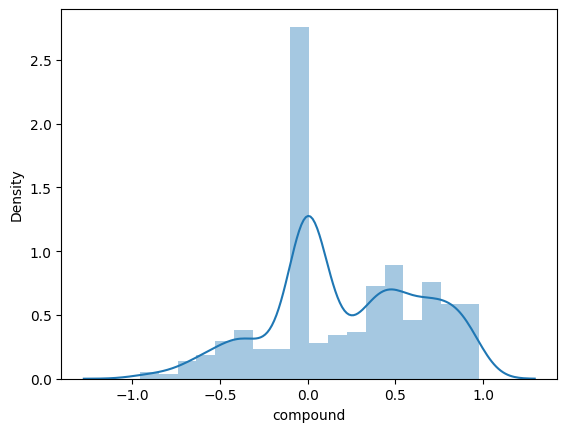

In [22]:
# Identify compound score distribution

sns.distplot(dfs_tweets['compound'])
plt.show()

In [10]:
# Function to determine tweets whether have positive, negative, or neutral sentiment

def vader_sent(comp_score):
  if comp_score >= 0.05:
    return "positive"
  elif comp_score < -0.05:
    return "negative"
  else:
    return "neutral"

In [11]:
# Determine english tweets whether have positive, negative, or neutral sentiment
dfs_tweets['polarity_vader'] = dfs_tweets['compound'].apply(lambda x: vader_sent(x))

In [12]:
dfs_tweets.head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity,text_translated,negative,neutral,positive,compound,polarity_vader
0,AldoBarasa,Al,Nyatanya pendidikan ku harus berhenti di semes...,2023-07-10 08:42:39,2023-07-10,09:00:00,nyatanya pendidikan ku harus berhenti di semes...,"['didik', 'ku', 'henti', 'semester', 'nang', '...",-5,negative,in fact my education has to stop in this semes...,0.191,0.652,0.157,-0.2732,negative
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah tim...,2023-07-10 08:42:36,2023-07-10,09:00:00,perasaan masih jauhan kantor gw dari rumah tim...,"['asa', 'jauh', 'kantor', 'gw', 'rumah', 'timb...",3,positive,the feeling is that my office is still far fro...,0.051,0.926,0.023,-0.3716,negative
2,admorae_,Admorae,@zakien6 Ini serius gak sih? 😭\nTp adek ku kel...,2023-07-10 08:42:36,2023-07-10,09:00:00,ini serius gak sih tp adek ku kelas smp juga...,"['gak', 'tp', 'adek', 'ku', 'kelas', 'smp', 'm...",-15,negative,Is this serious or not but my younger sibling ...,0.148,0.764,0.088,-0.5023,negative
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa...,2023-07-10 08:42:30,2023-07-10,09:00:00,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu t...,"['wlwkwlwlwlwlwlw', 'lu', 'tanam', 'lu', 'tuai...",-11,negative,wlwkwlwlwlwlwlw woah woah woah what you plant ...,0.176,0.736,0.087,-0.7005,negative
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kulia...",2023-07-10 08:42:22,2023-07-10,09:00:00,when u ngerantau sendirian kerja sambil kuliah...,"['when', 'u', 'ngerantau', 'kerja', 'kuliah', ...",-3,negative,when u wander alone work while studying colleg...,0.222,0.778,0.000,-0.2500,negative


In [13]:
sentiment_dist_vader = dfs_tweets['polarity_vader'].value_counts()
sentiment_dist_vader = pd.DataFrame(sentiment_dist_vader)
sentiment_dist_vader = sentiment_dist_vader.reset_index()
sentiment_dist_vader.head()

,index,polarity_vader
0,positive,530
1,neutral,286
2,negative,184


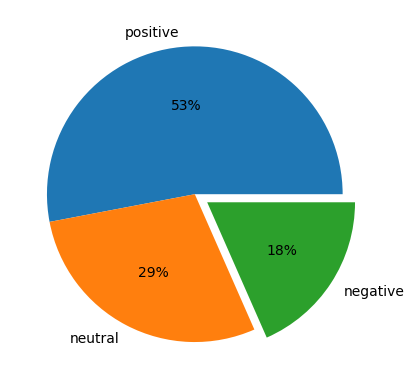

In [14]:
# Tweets sentiment distribution based on VADER lexicon

plt.pie(sentiment_dist_vader['polarity_vader'], labels=sentiment_dist_vader['index'],
        explode=[0, 0, 0.1], autopct='%.0f%%')
plt.show()

In [15]:
# Show top 10 positive tweets

pd.set_option('display.max_colwidth', 3000)
positive_tweets = dfs_tweets[dfs_tweets['polarity_vader'] == 'positive']
positive_tweets = positive_tweets[['text_cleaned', 'text_translated', 'positive', 'polarity_vader']].sort_values(by = 'positive', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_cleaned,text_translated,positive,polarity_vader
1,wkwkwk iya ga si ta suru kuliah di luar negri sekalian wkkw,wow,1.000,positive
2,cipeng bener nih alhamdulillah disekolahin sd islam sama smp islam baru sma masuk negeri kuliah negeri juga sd smp itu emg kalo bisa harus sekolah islam sih buat para muslim karna beda bgt pelajaran agamanya ama sekolah negeri wkwkwk,good luck,1.000,positive
3,kuliah kayanya,rich college,0.783,positive
4,libur kuliah,college holidays,0.722,positive
5,kuliah kayaknya,like college,0.714,positive
6,kuliah umum gratis,free public lectures,0.623,positive
7,temen kuliah gw,my college friend,0.615,positive
8,harapan untuk kuliah,hope for college,0.592,positive
9,ambisi adalah kemauan yang kuat untuk mencapai keberhasilan,ambition is a strong will to achieve success,0.583,positive
10,kuliah itu senengnya pas keterima doang,College is fun when I'm accepted,0.574,positive


In [16]:
# Show top 10 negative tweets

negative_tweets = dfs_tweets[dfs_tweets['polarity_vader'] == 'negative']
negative_tweets = negative_tweets[['text_cleaned', 'text_translated', 'negative', 'polarity_vader']].sort_values(by = 'negative', ascending=False)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_cleaned,text_translated,negative,polarity_vader
1,kuliah stress ngoding,college stress ngoding,0.583,negative
2,… aku menyesal membuang waktu hnsya kuliah… aku menyia nyiakan waktu nyazz,… I regretted wasting my time in college… I wasted my time nyazz,0.548,negative
3,kan gak jam kuliah,no class hours,0.524,negative
4,cape kuliah karna gaada papa,tired of studying because there is no father,0.459,negative
5,kalo cape kerja bawaan nya nangis kangen papa kalo cape kuliah bawaan nya nangis kangen papa,"If you're tired of work, the default is to cry, miss dad. If you're tired from college, the default is to cry, miss dad",0.458,negative
6,lagi kuliah capek capeknya,"I'm still in college, I'm tired",0.367,negative
7,bangsad nyesel banget kuliah disitu,The nation really regrets studying there,0.358,negative
8,jaegar gue capek kuliah nih gamau bantuin bikin tugas gitu,jaegar I'm tired of studying I don't want to help with a task like that,0.357,negative
9,berdasarkan pengalaman pacaran sama cowo bdg pas masih kuliah disana cowo bdg emg brengsek,"based on the experience of dating a bad guy when he was still in college there, the bad guy was a jerk",0.356,negative
10,roastingan mbak yenni menusuk banget ini sakit tapi tak berdarah tags puck jeje govinda jepang arab jam kuliah lcgc klasifikasi abah lala dasinya buro happold arema fc wekwan marlo sekolah t move hotstage award,"Roasting, Ms. Yenni, this stabs really hurts but doesn't bleed.",0.354,negative


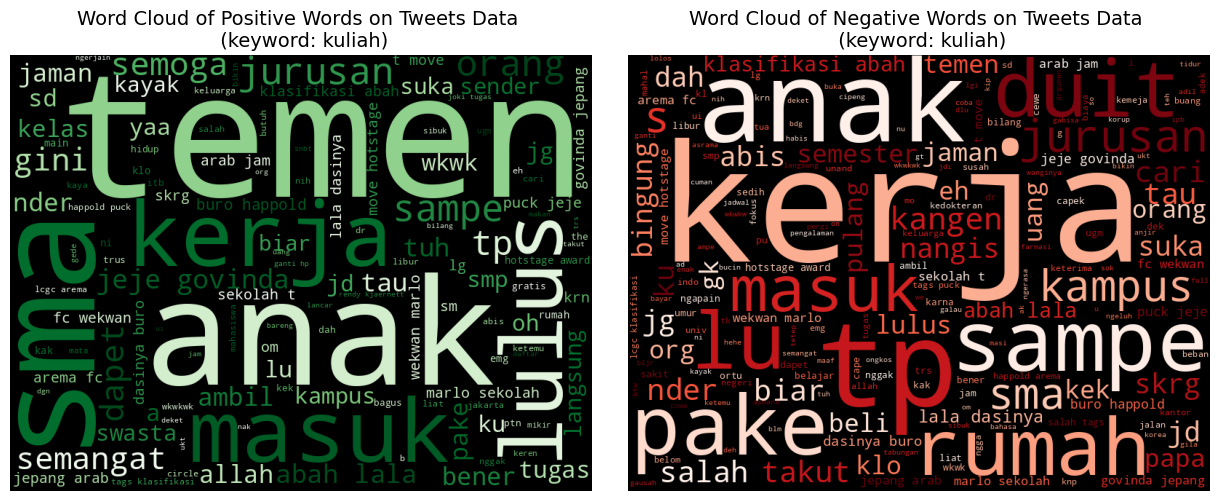

In [30]:
# Visualize positive and negative word cloud

list_stopwords = set(stopwords.words('indonesian'))
list_stopwords2 = stopword.get_stopword()
query_words={'kuliah','ga','kalo','gak','gw','bgt','udh','yg','yang'}
list_stopwords.update(list_stopwords2)
list_stopwords.update(query_words)

positive_tweets = dfs_tweets[dfs_tweets['polarity_vader'] == 'positive']
negative_tweets = dfs_tweets[dfs_tweets['polarity_vader'] == 'negative']

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
wordcloud_positive = WordCloud(stopwords = list_stopwords, width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(' '.join(positive_tweets.text_cleaned))
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (keyword: kuliah)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

wordcloud_negative = WordCloud(stopwords = list_stopwords, width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(' '.join(negative_tweets.text_cleaned))
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (keyword: kuliah)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

In [ ]:
# Download pretrained IndoBERT model

pretrained = "mdhugol/indonesia-bert-sentiment-classification"

model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

In [ ]:
# Predict twitter sentiment using pretrained IndoBERT model

result = df_tweets['text_cleaned'].progress_apply(sentiment_analysis)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
result.head()

0     [{'label': 'LABEL_2', 'score': 0.984238862991333}]
1    [{'label': 'LABEL_2', 'score': 0.8580245971679688}]
2     [{'label': 'LABEL_2', 'score': 0.993267297744751}]
3    [{'label': 'LABEL_2', 'score': 0.9968386888504028}]
4    [{'label': 'LABEL_2', 'score': 0.9851871132850647}]
Name: text_cleaned, dtype: object

In [ ]:
print(type(result))
print(type(result[0]))
print(type(results))
print(type(results[0]))

<class 'pandas.core.series.Series'>
<class 'list'>
<class 'list'>
<class 'tuple'>


In [ ]:
# Convert prediction result to dataframe

results = list(zip(*result))
results_df = pd.DataFrame(results).T.reset_index()
results_df = pd.concat([results_df.drop([0], axis=1), results_df[0].apply(pd.Series)], axis=1)
results_df = results_df.drop(columns=['index'], axis = 1)
results_df = results_df.rename(columns={'label':'polarity_indobert','score':'polarity_score_indobert'})

In [ ]:
# Replace polarity label from IndoBERT as listed in documentation above

replace_values = label_index
results_df = results_df.replace({'polarity_indobert': replace_values})

In [ ]:
results_df.head()

,polarity_indobert,polarity_score_indobert
0,negative,0.984239
1,negative,0.858025
2,negative,0.993267
3,negative,0.996839
4,negative,0.985187


In [ ]:
results_df.shape

(10000, 2)

In [ ]:
results_df['polarity_indobert'].value_counts()

negative    4725
neutral     2653
positive    2622
Name: polarity_indobert, dtype: int64

In [ ]:
# Merge df_tweets and df from IndoBERT prediction result

df_tweets = pd.concat([df_tweets, results_df], axis=1)
df_tweets.head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity,polarity_indobert,polarity_score_indobert
0,AldoBarasa,Al,"Nyatanya pendidikan ku harus berhenti di semester 2 ini,\nMau nangis y Allah, tapi gpp lah nanti klo ad uang bisa kuliah sendiri aj 🥺",2023-07-10 08:42:39,2023-07-10,09:00:00,nyatanya pendidikan ku harus berhenti di semester ini mau nangis y allah tapi gpp lah nanti klo ad uang bisa kuliah sendiri aj,"[didik, ku, henti, semester, nang, y, allah, gpp, klo, ad, uang, kuliah, aj]",-5,negative,negative,0.984239
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah timbang dari kampus rumah dulu klo liat dari gmaps\n\nTapi ongkos PP kampus rumah tuh lebih banyak daripada PP kantor rumah🫠\n\nPantesan jaman kuliah gw ngerasa seringnya ga punya duit. Habis di ongkos sksk,2023-07-10 08:42:36,2023-07-10,09:00:00,perasaan masih jauhan kantor gw dari rumah timbang dari kampus rumah dulu klo liat dari gmaps tapi ongkos pp kampus rumah tuh lebih banyak daripada pp kantor rumah pantesan jaman kuliah gw ngerasa seringnya ga punya duit habis di ongkos sksk,"[asa, jauh, kantor, gw, rumah, timbang, kampus, rumah, klo, liat, gmaps, ongkos, pp, kampus, rumah, tuh, pp, kantor, rumah, pantesan, jaman, kuliah, gw, ngerasa, ga, duit, habis, ongkos, sksk]",3,positive,negative,0.858025
2,admorae_,Admorae,"@zakien6 Ini serius gak sih? 😭\nTp adek ku kelas 2 SMP juga mikirnya udah mau lanjut kuliah ke luar negeri aja, kerja keluar negeri, soalnya cari kerja di Indo susah dll. Apa remaja saat ini emang udah mikir jauh banget kayak gitu??? 😶",2023-07-10 08:42:36,2023-07-10,09:00:00,ini serius gak sih tp adek ku kelas smp juga mikirnya udah mau lanjut kuliah ke luar negeri aja kerja keluar negeri soalnya cari kerja di indo susah dll apa remaja saat ini emang udah mikir jauh banget kayak gitu,"[gak, tp, adek, ku, kelas, smp, mikirnya, kuliah, negeri, kerja, negeri, cari, kerja, indo, susah, remaja, mikir, kayak]",-15,negative,negative,0.993267
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu tanam itu yg lu tuai NIKMATIN BUAH DARI KESALAHAN LO percaya ga percaya kalo dariawal udh ga jujur sampai akhir juga bakalan banyak problem yg nimpa kamu. baru segini aja udh curang gmn masuk kuliah lu joki? https://t.co/0C0XOTjJU3,2023-07-10 08:42:30,2023-07-10,09:00:00,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu tanam itu yg lu tuai nikmatin buah dari kesalahan lo percaya ga percaya kalo dariawal udh ga jujur sampai akhir juga bakalan banyak problem yg nimpa kamu baru segini aja udh curang gmn masuk kuliah lu joki,"[wlwkwlwlwlwlwlw, lu, tanam, lu, tuai, nikmatin, buah, salah, lo, percaya, ga, percaya, kalo, dariawal, udh, ga, jujur, problem, nimpa, gin, udh, curang, gmn, masuk, kuliah, lu, joki]",-11,negative,negative,0.996839
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kuliah, beuh, meledak~",2023-07-10 08:42:22,2023-07-10,09:00:00,when u ngerantau sendirian kerja sambil kuliah beuh meledak,"[when, u, ngerantau, kerja, kuliah, beuh, ledak]",-3,negative,negative,0.985187


In [ ]:
df_tweets.to_csv('/content/drive/My Drive/twitter_scraping_kuliah_sentiment.csv', sep=';', index=False)

In [32]:
df_tweets = pd.read_csv('/content/drive/My Drive/twitter_scraping_kuliah_sentiment.csv', sep=';', lineterminator='\n')

In [ ]:
sentiment_dist_bert = df_tweets['polarity_indobert'].value_counts()
sentiment_dist_bert = pd.DataFrame(sentiment_dist_bert)
sentiment_dist_bert = sentiment_dist_bert.reset_index()
sentiment_dist_bert.head()

,index,polarity_indobert
0,negative,4725
1,neutral,2653
2,positive,2622


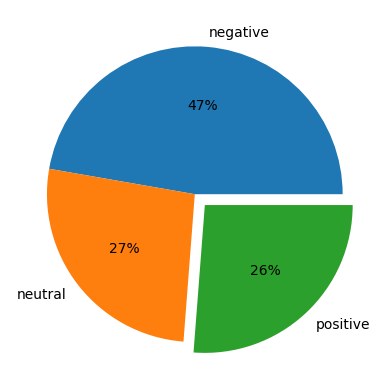

In [ ]:
# Tweets sentiment distribution

plt.pie(sentiment_dist_bert['polarity_indobert'], labels=sentiment_dist_bert['index'],
        explode=[0, 0, 0.1], autopct='%.0f%%')
plt.show()

In [ ]:
# Show top 10 positive tweets

pd.set_option('display.max_colwidth', None)
positive_tweets = df_tweets[df_tweets['polarity_indobert'] == 'positive']
positive_tweets = positive_tweets[['text_cleaned', 'polarity_score_indobert', 'polarity_indobert']].sort_values(by = 'polarity_score_indobert', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_cleaned,polarity_score_indobert,polarity_indobert
1,one of my grateful things bisa kuliah di bali adalah bisa mantai sepuasnya enak banget kalo lagi banyak pikiran ke pantai malem malem,0.997988,positive
2,wah seru banget kalo ada gw dukung dan seneng sih kalo di indo ada mcd begini soalnya jaman kuliah dulu gw sering nugas sampe tengah malem di mcd karena bisa dapet free inet dan makan malem bersih,0.997947,positive
3,totebag serut alita totebag kuliah recommended banget tas nya gede muat banyak bahan nya premium design nya juga bagus lois totebag puffy bag vol,0.997815,positive
4,tas ransel lucu tapi murah dari himeku ukurannya pas dibadan muat banyak ada slot laptopnya juga materialnya tebel kokoh tapi nggak kaku talinya kuat busanya tebel worth every penny cocok banget buat kuliah sekolah atau kerja juga link,0.997810,positive
5,flatshoes rekomended cocok banget buat kuliah kerja atau jalan empukkk ga bikin kaki lecet ga norak dan indahhhh punyaku warna beige,0.997807,positive
6,ini segiempat favorite akuu udah dari sma aku pake kalo main sampe sekarang udah kuliah aweet bahannya bella square yaa warna frappucino waktu itu aku beli di shopee tapi pas dateng malah dusty purple gitu cakep kayanya salah tapi gapapa soalnya bagus dan enakeun,0.997807,positive
7,salah satu favorit menu buat sarapan pas kuliah dulu harganya ribu rupiah satu bungkus nikmat dan murah meriah,0.997794,positive
8,rekomendasi rokskirt lucuu banget warnanya jg macem cocok buat kuliah atau jalan pokoknya cantik bgt gakuatt elle skirt,0.997765,positive
9,ini empuk banget harganya an juga buat kuliah enak banget,0.997740,positive
10,jujur series bl thai terbest menurut gua yang awalnya gua kira yang mana seme yang mana uke akhirnya salah paham anj ketuker dan gua suka banget pas lagi sesi pengkaderan ala kuliah gitu,0.997626,positive


In [ ]:
# Show top 10 negative tweets

negative_tweets = df_tweets[df_tweets['polarity_indobert'] == 'negative']
negative_tweets = negative_tweets[['text_cleaned', 'polarity_score_indobert', 'polarity_indobert']].sort_values(by = 'polarity_score_indobert', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_cleaned,polarity_score_indobert,polarity_indobert
1,ekspektasi liburan semester kali ini mau bener² istirahat realita pindahan rumah arisan perumahan acara jalanjalan satu komplek ini yg punya hajatan ibu yg ikut mikir saya juga dari kuliah di jurusan sebelumnya sampai jurusan baru ngga pernah tenang liburan ku,0.352698,negative
2,tidak ada kata syulit selain kuliah tekgem,0.361364,negative
3,kuliah matkul pengembangan ekskul merenung soalnya dosennya pembina kuliah matkul kepemimpinan merenung sama apa yang udh dilakuin selama ngejabat,0.368236,negative
4,fiks aku ngundurrin diri buat daftar lanjut kuliah ke s tahun ini mau lanjut studi butuh cuan banyak bet kudu nabung dulu,0.372550,negative
5,gue aja naro spi segitu aja perlu dikoordinasiin dulu ama ortu tapi keknya ortu juga dananya udh siap buat gue kuliah even yang nyari kuliah ttg fk bukan gue melainkan mak gue gue search nya jalur masuk kalo mak gue uktnya sebelum gue ke uner gue disuruh ke uii and muahal pol,0.377431,negative
6,kalo lagi rungkad kuliah si,0.385435,negative
7,pas sma sering belajar di mcd yang buka jam sekarang kuliah udah bingung cari tempat belajar yang nyaman dan buka jam kalo ada yang tau study room atau coworking space di semarang yang buka jam pls let me know,0.385827,negative
8,uncover jmn aku msh sekolah sma amp kuliah ktmu pengemis diarea malioboro aku ngamati trs kok mirip sopo trs pagi sekitar jam pagi aku rutin jogging dpn rmh dan pengemis tsb rutin lwt jam segitu bisa jln tegap tp pas dines ngemis kaki dibuntel perban,0.388913,negative
9,aku pengen kuliah tujuannya biar ngak sempat mikirin masalah hidup,0.390050,negative
10,happy that im used my own money to buy it ga pernah minta orang tua suami apalagi org lain dari kuliah gw ush nyambi part time ngajar bimbel sblm lulus bahkan gw udh kerja di non profit company udh nikah pun gw ga pernah ngerek² minta duit suami,0.392341,negative


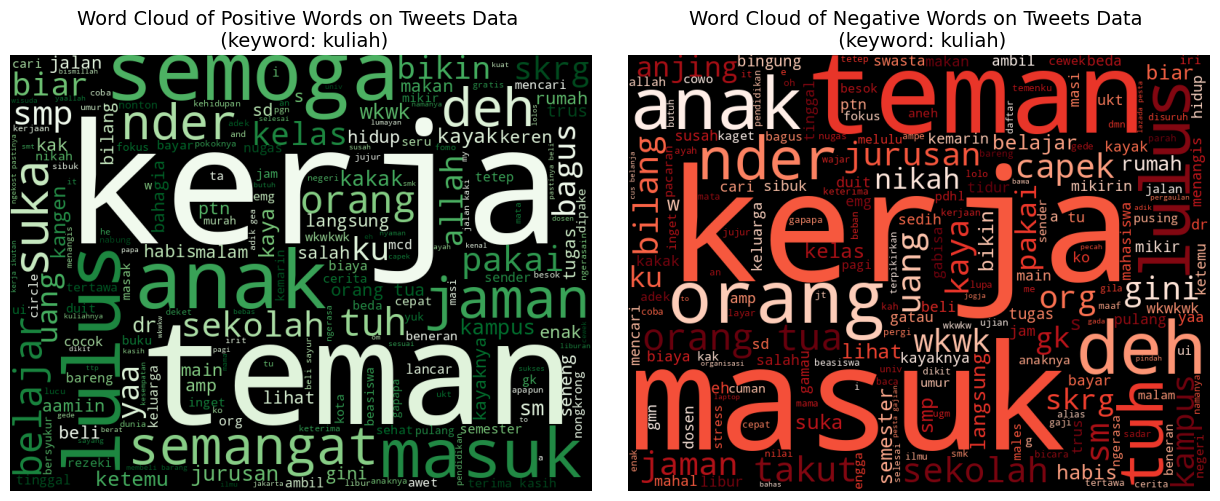

In [ ]:
# Visualize positive and negative word cloud

list_stopwords = set(stopwords.words('indonesian'))
list_stopwords2 = stopword.get_stopword()
query_words={'kuliah','ga','kalo','gak','gw','bgt','udh','yg','yang'}
list_stopwords.update(list_stopwords2)
list_stopwords.update(query_words)

positive_tweets = df_tweets[df_tweets['polarity_indobert'] == 'positive']
negative_tweets = df_tweets[df_tweets['polarity_indobert'] == 'negative']

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
wordcloud_positive = WordCloud(stopwords = list_stopwords, width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(' '.join(positive_tweets.text_cleaned_slang))
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (keyword: kuliah)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

wordcloud_negative = WordCloud(stopwords = list_stopwords, width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(' '.join(negative_tweets.text_cleaned_slang))
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (keyword: kuliah)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

In [33]:
df_tweets.head()

,screen_name,username,text,time_posted,date,time,text_cleaned,text_preprocessed,polarity_score,polarity,polarity_indobert,polarity_score_indobert
0,AldoBarasa,Al,"Nyatanya pendidikan ku harus berhenti di semester 2 ini,\nMau nangis y Allah, tapi gpp lah nanti klo ad uang bisa kuliah sendiri aj 🥺",2023-07-10 08:42:39,2023-07-10,09:00:00,nyatanya pendidikan ku harus berhenti di semester ini mau nangis y allah tapi gpp lah nanti klo ad uang bisa kuliah sendiri aj,"['didik', 'ku', 'henti', 'semester', 'nang', 'y', 'allah', 'gpp', 'klo', 'ad', 'uang', 'kuliah', 'aj']",-5,negative,negative,0.984239
1,tortoisemr_,fa🐢,Perasaan masih jauhan kantor gw dari rumah timbang dari kampus rumah dulu klo liat dari gmaps\n\nTapi ongkos PP kampus rumah tuh lebih banyak daripada PP kantor rumah🫠\n\nPantesan jaman kuliah gw ngerasa seringnya ga punya duit. Habis di ongkos sksk,2023-07-10 08:42:36,2023-07-10,09:00:00,perasaan masih jauhan kantor gw dari rumah timbang dari kampus rumah dulu klo liat dari gmaps tapi ongkos pp kampus rumah tuh lebih banyak daripada pp kantor rumah pantesan jaman kuliah gw ngerasa seringnya ga punya duit habis di ongkos sksk,"['asa', 'jauh', 'kantor', 'gw', 'rumah', 'timbang', 'kampus', 'rumah', 'klo', 'liat', 'gmaps', 'ongkos', 'pp', 'kampus', 'rumah', 'tuh', 'pp', 'kantor', 'rumah', 'pantesan', 'jaman', 'kuliah', 'gw', 'ngerasa', 'ga', 'duit', 'habis', 'ongkos', 'sksk']",3,positive,negative,0.858025
2,admorae_,Admorae,"@zakien6 Ini serius gak sih? 😭\nTp adek ku kelas 2 SMP juga mikirnya udah mau lanjut kuliah ke luar negeri aja, kerja keluar negeri, soalnya cari kerja di Indo susah dll. Apa remaja saat ini emang udah mikir jauh banget kayak gitu??? 😶",2023-07-10 08:42:36,2023-07-10,09:00:00,ini serius gak sih tp adek ku kelas smp juga mikirnya udah mau lanjut kuliah ke luar negeri aja kerja keluar negeri soalnya cari kerja di indo susah dll apa remaja saat ini emang udah mikir jauh banget kayak gitu,"['gak', 'tp', 'adek', 'ku', 'kelas', 'smp', 'mikirnya', 'kuliah', 'negeri', 'kerja', 'negeri', 'cari', 'kerja', 'indo', 'susah', 'remaja', 'mikir', 'kayak']",-15,negative,negative,0.993267
3,shoheimatsush,🎸,@schfess wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu tanam itu yg lu tuai NIKMATIN BUAH DARI KESALAHAN LO percaya ga percaya kalo dariawal udh ga jujur sampai akhir juga bakalan banyak problem yg nimpa kamu. baru segini aja udh curang gmn masuk kuliah lu joki? https://t.co/0C0XOTjJU3,2023-07-10 08:42:30,2023-07-10,09:00:00,wlwkwlwlwlwlwlw waduh waduh waduh apa yg lu tanam itu yg lu tuai nikmatin buah dari kesalahan lo percaya ga percaya kalo dariawal udh ga jujur sampai akhir juga bakalan banyak problem yg nimpa kamu baru segini aja udh curang gmn masuk kuliah lu joki,"['wlwkwlwlwlwlwlw', 'lu', 'tanam', 'lu', 'tuai', 'nikmatin', 'buah', 'salah', 'lo', 'percaya', 'ga', 'percaya', 'kalo', 'dariawal', 'udh', 'ga', 'jujur', 'problem', 'nimpa', 'gin', 'udh', 'curang', 'gmn', 'masuk', 'kuliah', 'lu', 'joki']",-11,negative,negative,0.996839
4,alyrumm,L Y L Y,"when u ngerantau sendirian, kerja sambil kuliah, beuh, meledak~",2023-07-10 08:42:22,2023-07-10,09:00:00,when u ngerantau sendirian kerja sambil kuliah beuh meledak,"['when', 'u', 'ngerantau', 'kerja', 'kuliah', 'beuh', 'ledak']",-3,negative,negative,0.985187


In [107]:
# Remove duplicate tweets

df_tweets_nodup = df_tweets.drop_duplicates(subset=['text_cleaned'], keep=False)
df_tweets_nodup = df_tweets_nodup.reset_index(drop=True)

In [108]:
df_tweets.shape

(10000, 14)

In [109]:
df_tweets_nodup.shape

(9582, 14)

In [110]:
list_stopwords = set(stopwords.words('indonesian'))
list_stopwords2 = stopword.get_stopword()
query_words={'kuliah','ga','kalo','gak','gw','bgt','udh','yg','yang','dan'}
list_stopwords.update(list_stopwords2)
list_stopwords.update(query_words)

In [111]:
def remove_indonesian_stop(data, feature) :
    stopwords = list_stopwords
    filtered = []
    for text in data[feature] :
        text_list = []
        for word in text.split() :
            if word not in stopwords :
                text_list.append(word)
        text_list = ' '.join(text_list)
        filtered.append(text_list)
    return filtered

df_tweets_nodup['text_cleaned_nostop'] = remove_indonesian_stop(df_tweets_nodup, 'text_cleaned')

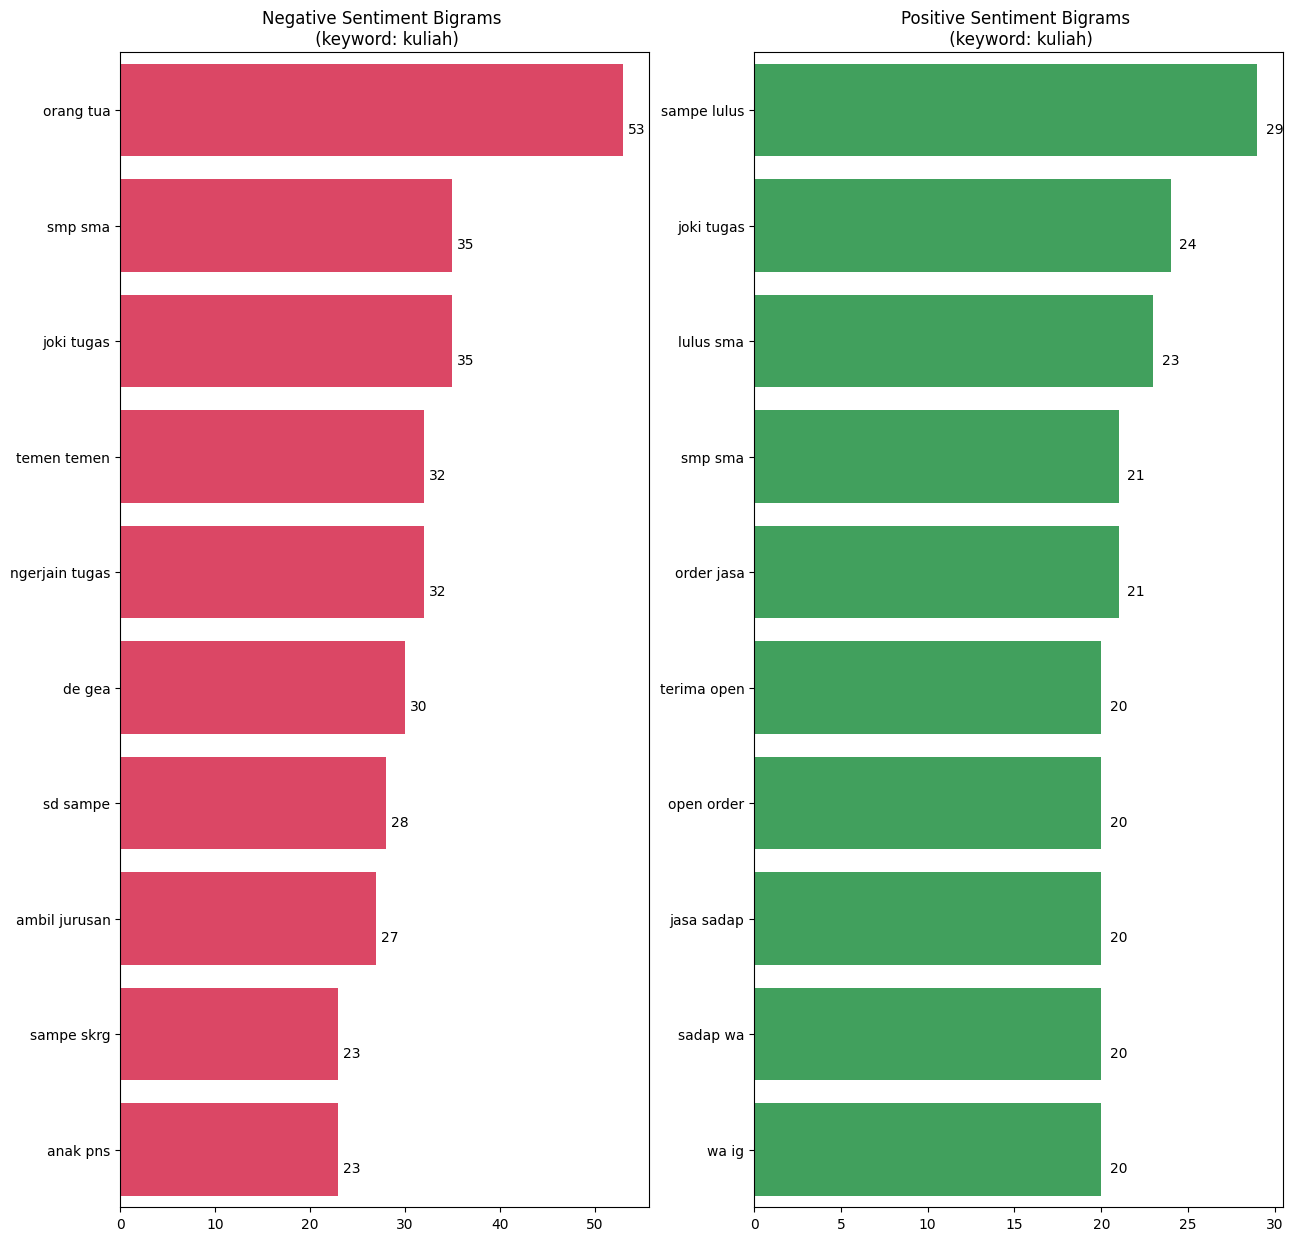

In [154]:
# Generate bigram from positive and negative tweets

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(15,15))
top_tweet_bigrams=get_top_tweet_bigrams(df_tweets_nodup[(df_tweets_nodup['polarity'] == 'negative')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = '#F42E56')
plt.title('Negative Sentiment Bigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

top_tweet_bigrams=get_top_tweet_bigrams(df_tweets_nodup[(df_tweets_nodup['polarity'] == 'positive')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = '#31B057')
plt.title('Positive Sentiment Bigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

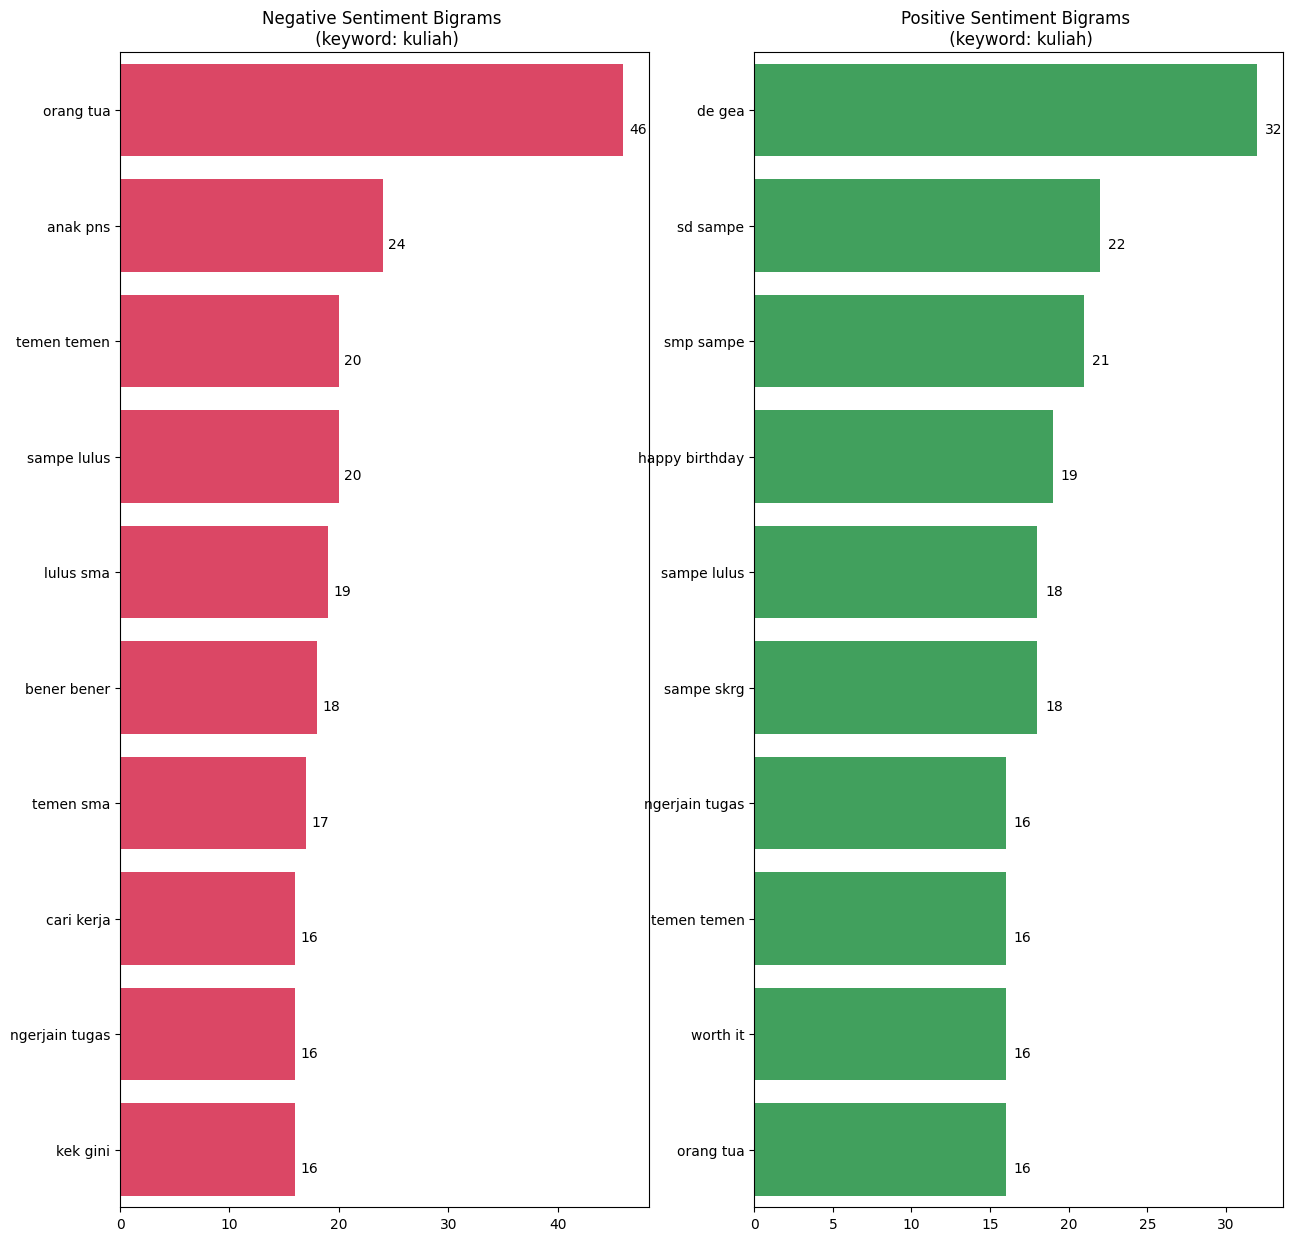

In [155]:
# Generate bigram from positive and negative tweets

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(15,15))
top_tweet_bigrams=get_top_tweet_bigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'negative')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = '#F42E56')
plt.title('Negative Sentiment Bigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

top_tweet_bigrams=get_top_tweet_bigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = '#31B057')
plt.title('Positive Sentiment Bigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

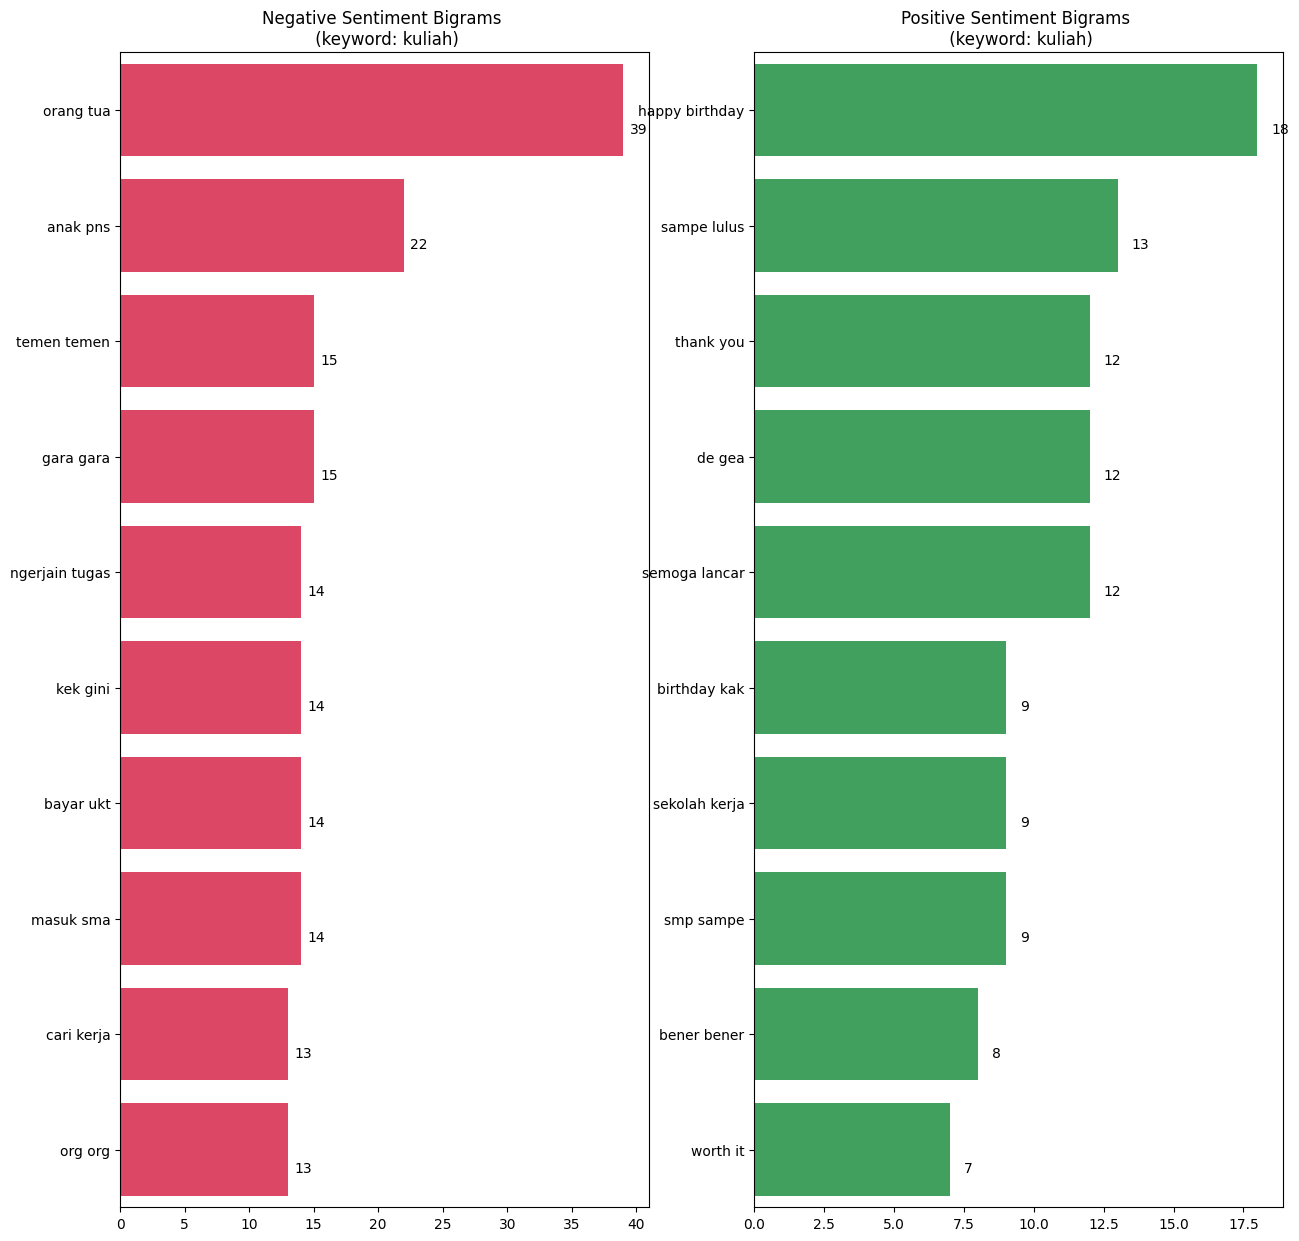

In [147]:
# Generate bigram from positive and negative tweets

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(15,15))
top_tweet_bigrams=get_top_tweet_bigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'negative') & (df_tweets_nodup['polarity'] == 'negative')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = '#F42E56')
plt.title('Negative Sentiment Bigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

top_tweet_bigrams=get_top_tweet_bigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive') & (df_tweets_nodup['polarity'] == 'positive')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = '#31B057')
plt.title('Positive Sentiment Bigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_bigrams :
    plt.text(i[1]+.5, index+.2, i[1])
    index+=1

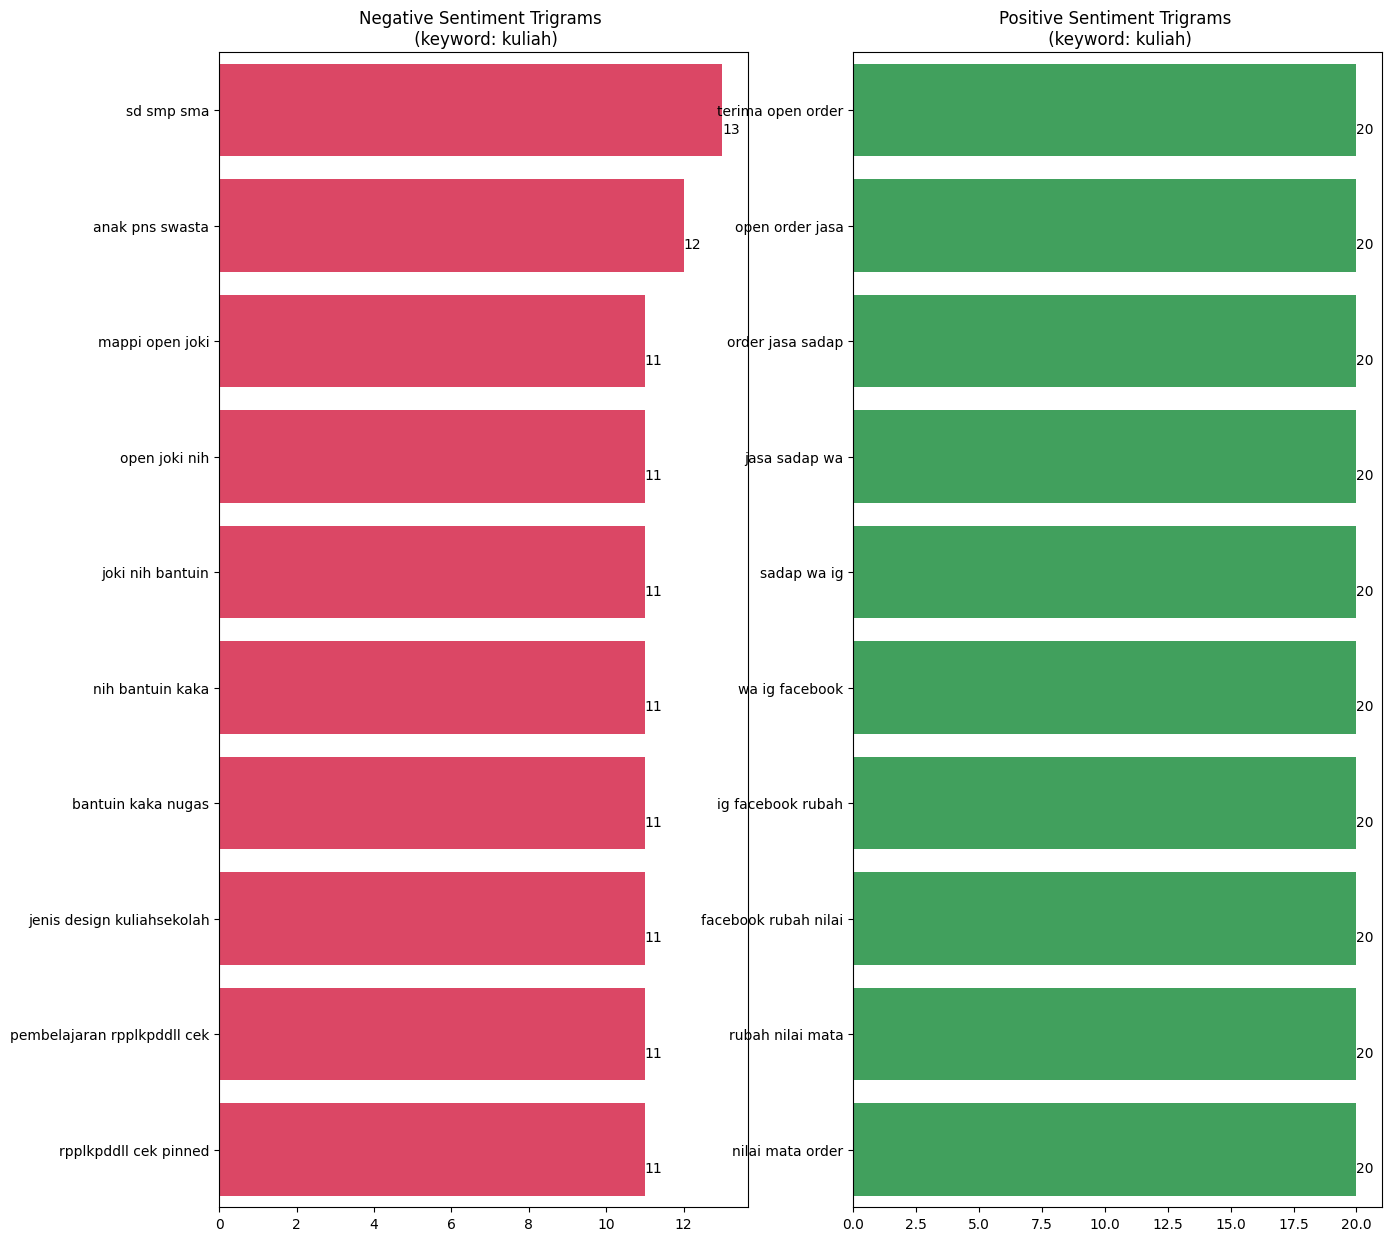

In [158]:
# Generate trigram from positive and negative tweets

def get_top_tweet_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(15,15))
top_tweet_trigrams=get_top_tweet_trigrams(df_tweets_nodup[(df_tweets_nodup['polarity'] == 'negative')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = '#F42E56')
plt.title('Negative Sentiment Trigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_trigrams :
    plt.text(i[1], index+.2, i[1])
    index+=1

top_tweet_trigrams=get_top_tweet_trigrams(df_tweets_nodup[(df_tweets_nodup['polarity'] == 'positive')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = '#31B057')
plt.title('Positive Sentiment Trigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_trigrams :
    plt.text(i[1], index+.2, i[1])
    index+=1

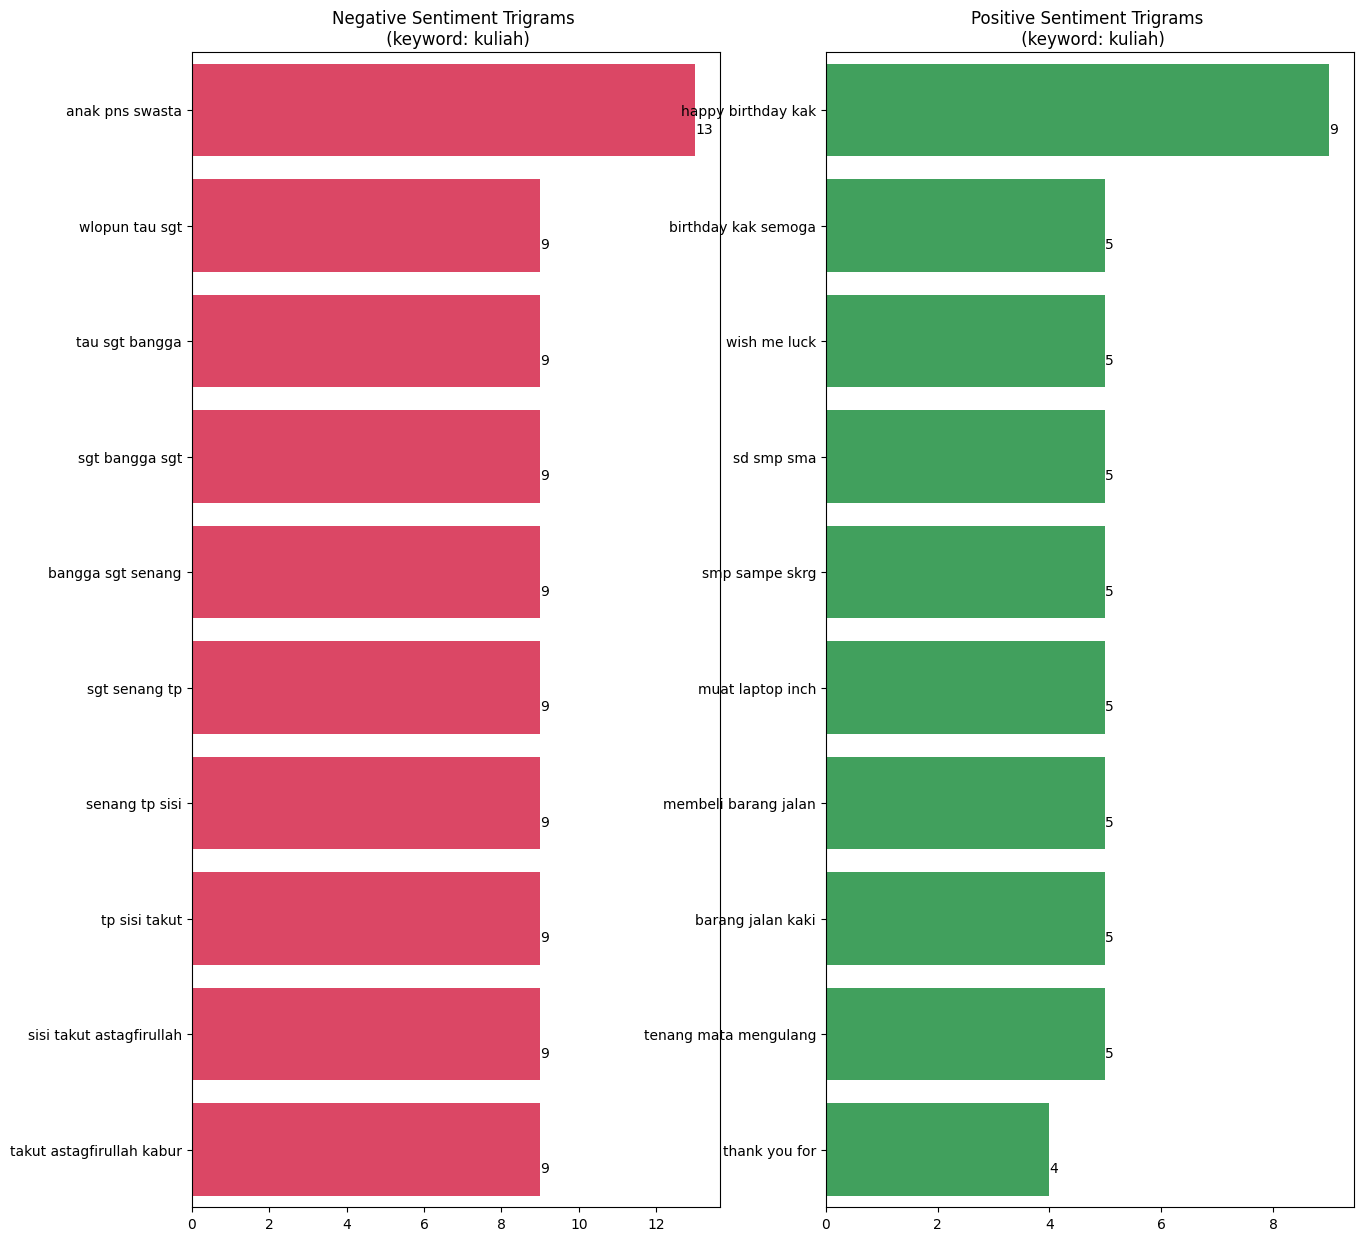

In [159]:
# Generate trigram from positive and negative tweets

def get_top_tweet_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(15,15))
top_tweet_trigrams=get_top_tweet_trigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'negative')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = '#F42E56')
plt.title('Negative Sentiment Trigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_trigrams :
    plt.text(i[1], index+.2, i[1])
    index+=1

top_tweet_trigrams=get_top_tweet_trigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = '#31B057')
plt.title('Positive Sentiment Trigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_trigrams :
    plt.text(i[1], index+.2, i[1])
    index+=1

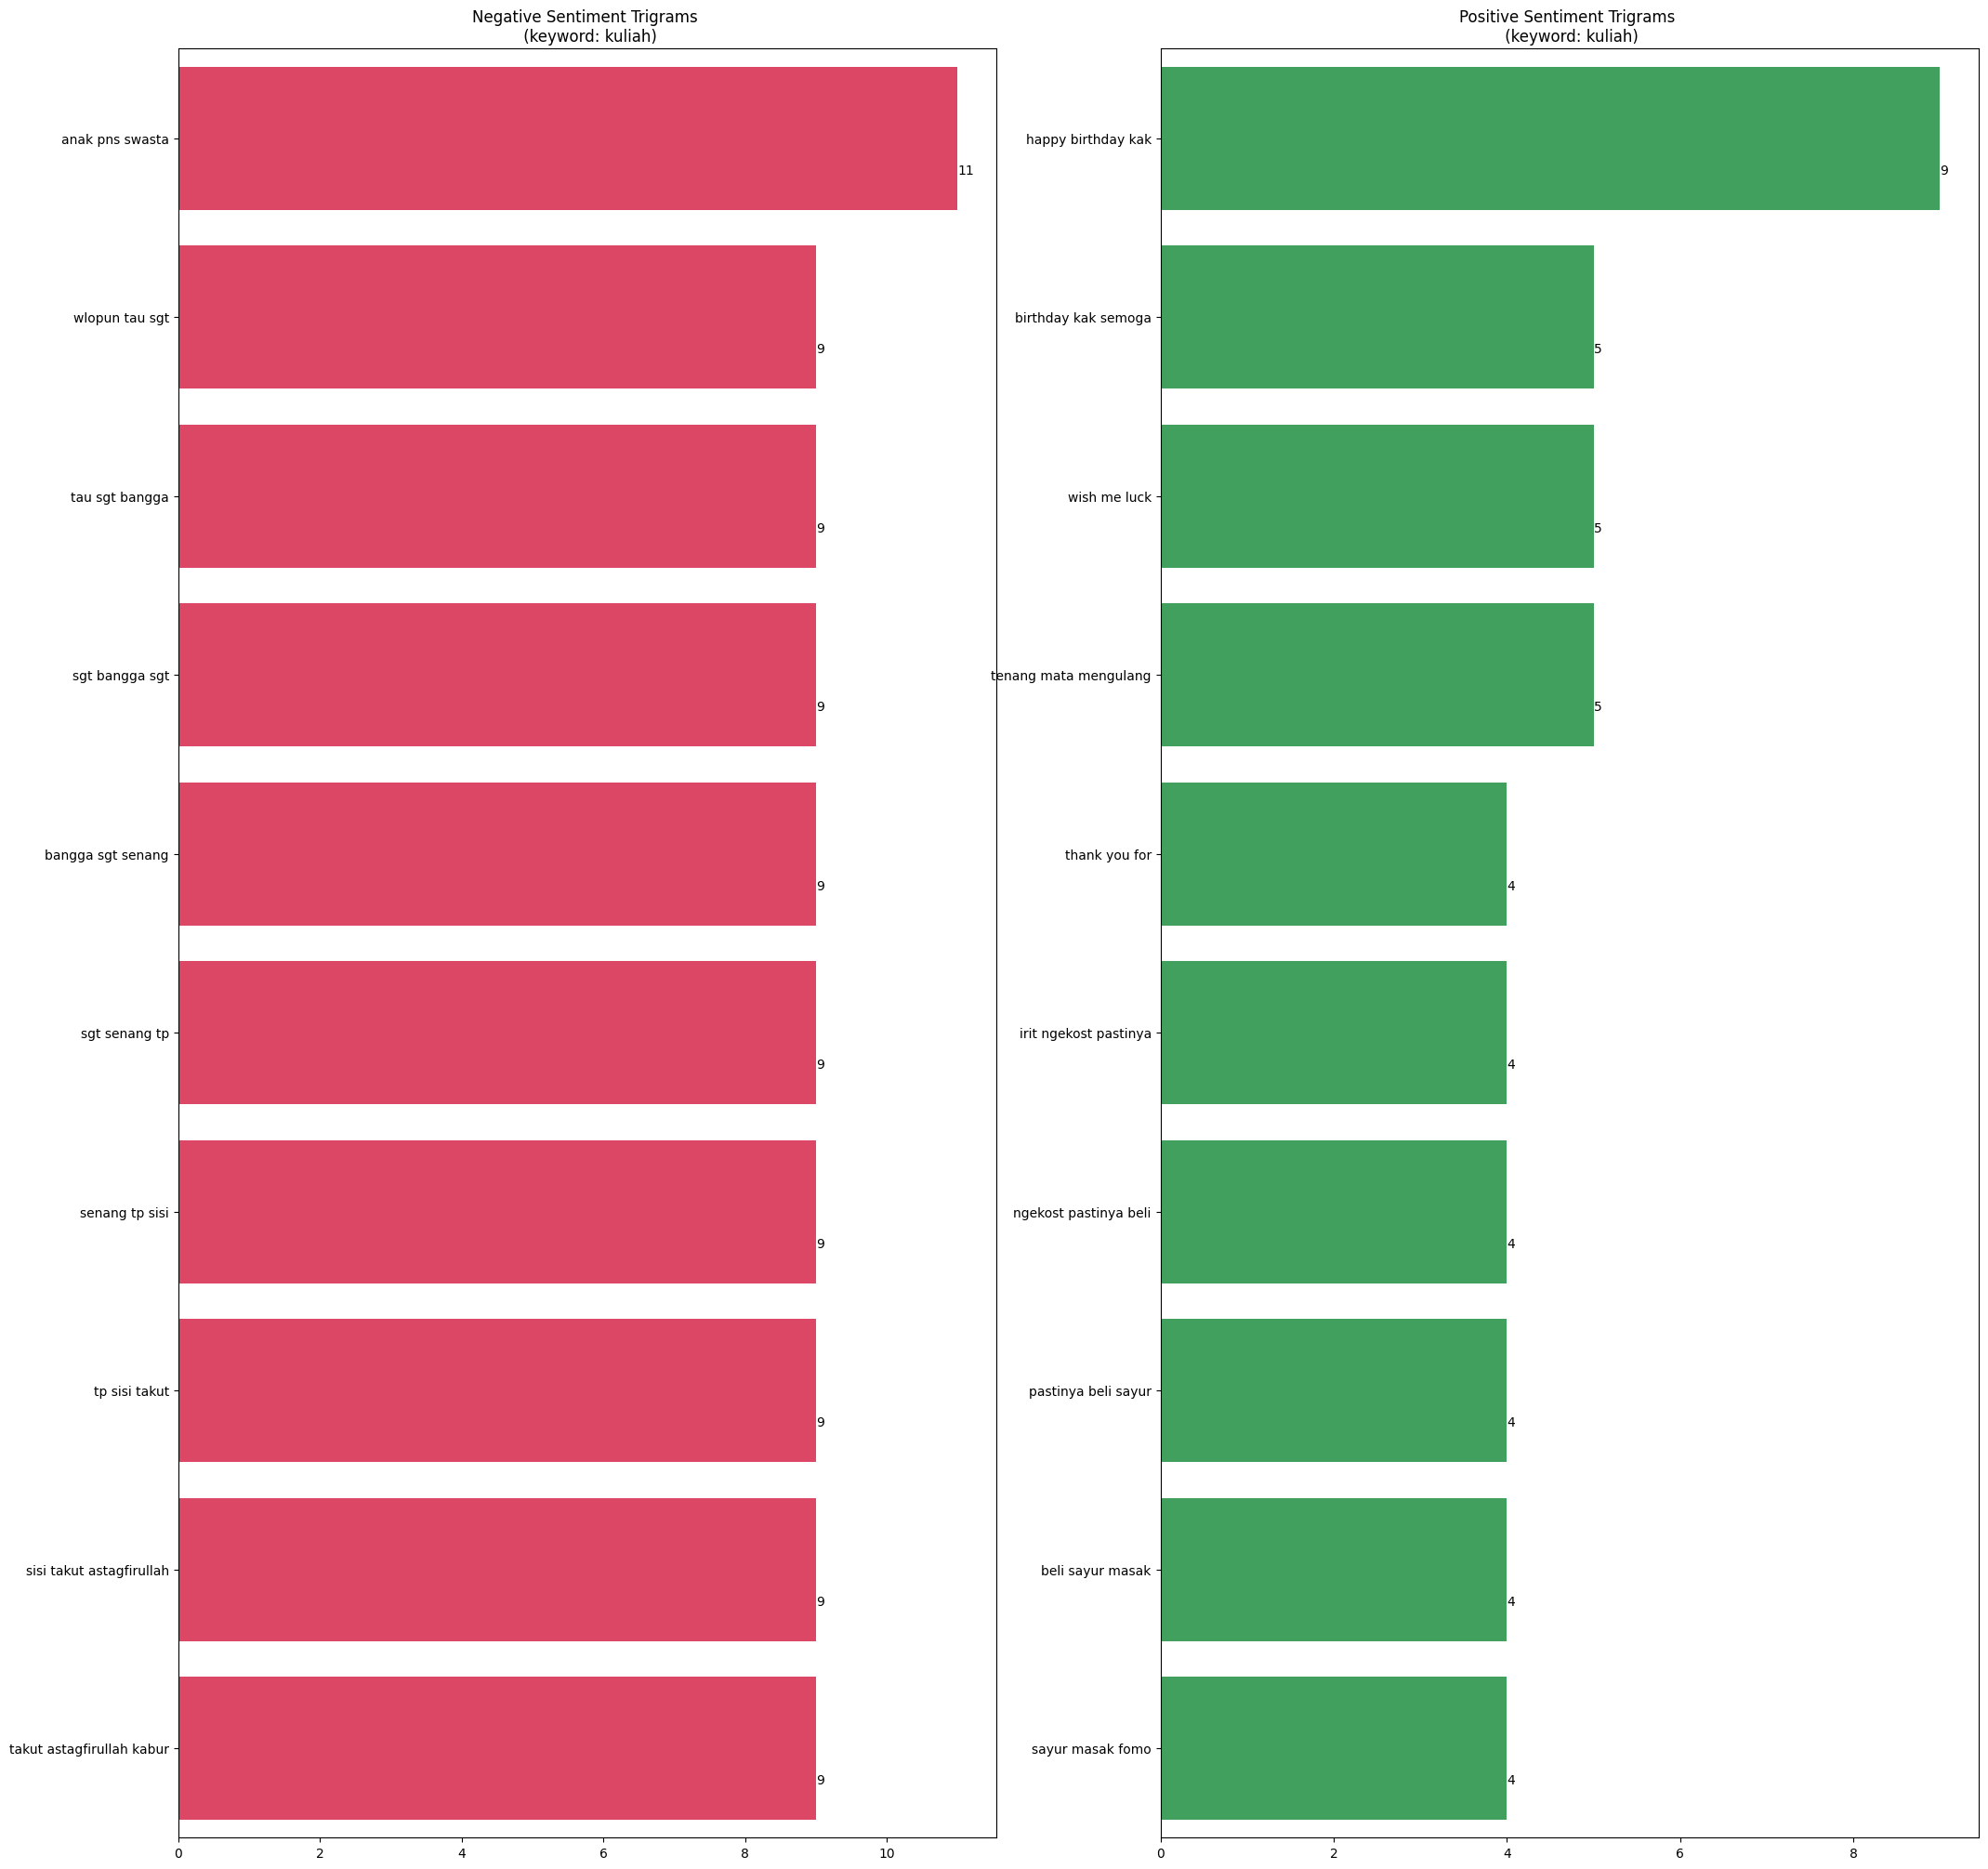

In [148]:
# Generate trigram from positive and negative tweets

def get_top_tweet_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
fig = plt.figure(figsize=(25,25))
top_tweet_trigrams=get_top_tweet_trigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'negative') & (df_tweets_nodup['polarity'] == 'negative')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
fig.add_subplot(1, 2, 1)
sns.barplot(x=y,y=x, color = '#F42E56')
plt.title('Negative Sentiment Trigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_trigrams :
    plt.text(i[1], index+.2, i[1])
    index+=1

top_tweet_trigrams=get_top_tweet_trigrams(df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive') & (df_tweets_nodup['polarity'] == 'positive')]['text_cleaned_nostop'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
fig.add_subplot(1, 2, 2)
sns.barplot(x=y,y=x, color = '#31B057')
plt.title('Positive Sentiment Trigrams \n (keyword: kuliah)')
index = 0
for i in top_tweet_trigrams :
    plt.text(i[1], index+.2, i[1])
    index+=1

In [149]:
# Show top 20 specific tweets with specific word

substring = 'happy birthday'
specific_tweets = df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive') & (df_tweets_nodup['polarity'] == 'positive')]
specific_tweets = specific_tweets[['text_cleaned', 'polarity', 'polarity_indobert']]
specific_tweets = specific_tweets[specific_tweets.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
specific_tweets[0:20]

,text_cleaned,polarity,polarity_indobert
16,happy birthday kak sehat selalu ya kak makin lancar terus rezeky nya dan semangat terus kak kuliah nya smga cpt selesai dan lancar aminn yra,positive,positive
359,hai kak thankyou udah mau berbagi happy birthday ya kak semoga sehat sllu mudah rezeki lancar dan sllu dimudahkan segala urusan kakak semoga tahun ini kuliah kakak lancar sampai selesai aamiin god bless u goodluck wish me luck‍,positive,positive
641,happy birthday kak sania semoga sehat dan sukses selalu semoga tahun ini kuliah kakak lancar sampai selesai yaa aamiin,positive,positive
1002,happy birthday semoga kuliah nya lancarr yaa,positive,positive
1234,sebelumnya makasi ya kaa uda ngadain ga ini happy birthday ya kaselamat bertambah umur kasehat sehat teruspanjang umur moga apa yang kaka inginkan segera terkabul dan aku doakan kuliah kaka dilancarkan sampe selesai semangat teruss kaaa,positive,positive
1351,happy birthday yaaa smoga kuliah kakak bisa lancar semulus dan selicin muka wonyoung sampai selesai bisa lulus dengan cum laude ipk yang tinggi aamiiinnn,positive,positive
1474,happy birthday kamuu semoga kuliah nya lancar selalu nya jadi mahasiswi yang berprestasi,positive,positive
1485,happy birthday kak semoga kuliah yang emang kadang bikin stresseu ini bisa dilalui dengan happy happy ya semoga nanti hasil akhirnya memuaskan,positive,positive
1626,happy birthday kak sania semoga kuliah kakak tahun ini diberikan kelancaran dan kemudahan sampai selesai aamiin semangat juga ya kak kuliahnya terimakasih sudah memberikan kesempatan dan kebahagiaan lewat ga ini kak i hope you have a sweet warming comfy day,positive,positive
1704,omooo happy birthdayy syg kuu aku liat notif line kmrn ktanya ultah km “besok” xixixixixi slamat thun yh smoga lancar kuliah nnti,positive,positive


In [150]:
# Show top 20 specific tweets with specific word

substring = 'orang tua'
specific_tweets = df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'negative') & (df_tweets_nodup['polarity'] == 'negative')]
specific_tweets = specific_tweets[['text_cleaned', 'polarity', 'polarity_indobert']]
specific_tweets = specific_tweets[specific_tweets.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
specific_tweets[0:20]

,text_cleaned,polarity,polarity_indobert
114,aku juga anak pns alhamdulillah kuliah di kedokteran swasta berkat orang tua yang hidup nya sangat sederhana plus udah nanyain aku dari tk cita² nya mau jdi apa krna aku dri tk jawabnya mau jdi dokter orangtua langsung nabung bayangin nabung dari tk kaya gimana,negative,negative
1181,aturan kolott tetep di ikutin gak peduli zaman udah berubah patriarki bangeeeet anak tidak bisa bebas memilih masa depan semua sekolah dari tk sampe kuliah ditentukan orang tua menolak di cap tidak nurut orang tua mudah terpengaruh omongan orang luar,negative,negative
1523,btul bukan tentang sukses tp ttg tuntutan orang tua yang gk rela anaknya milih kuliah di ptn daripada kedinasan masih aja tahun skrg gapapa kuliah dlu tahun depan coba ya iyh ak coba,negative,negative
1621,kalau dipikir pikir yaaa emang si gua gabakal bisa gitu kaya kuliah dan dapet kerja secara langsung malah jadi beban orang tua aja apa lagi kalo mau cari kerja harus memperluas koneksi dulu hmmmmzz,negative,negative
1879,kuliah mau sejauh apapun orang aku sendiri yang ngejalanin orang tuaku aja ngerestuin kok‍,negative,negative
1942,lahh bagus president dong gk ada hubungannya orang tua pns dan anak kuliah di swasta menurut aku itu juga bukan tindakan korupsi coba temennya bisa di suruh baca kegiatan yang termasuk kedalam korupsi dulu kurang literatur kyanya dia ups,negative,negative
2142,untungnya ini masih kuliah online jadi dirumah orang tua yg ngurusin buat membasmi para kutu ini…,negative,negative
2583,jadi kalo kalian tidak seberuntung gw dan tidak punya orang tua yang sama seperti gw ya buat diri kelean beruntung udah kerja tu sisihin duit buat kuliah kek kalo gak disekolahin ama orang tua ya sekolahin diri klean sendiri,negative,negative
2587,aku aja yg kuliah bisa habis rb buat keperluan dapur sendiri lo ini kan elu berdua gila sih emang cowoknya yg nyusahin bisa nikahin anak orang to ndak bisa kasih dia nafkah orang tuanya alah liat ini nyesel sih di beri izin ke dia nikah,negative,negative
2591,jadi yang nyuruh gw kawin mulu minimal nyumbang duitlah buat biaya kuliah anak gw jujurly gw gak mau anak gw lahir dengan kondisi orang tuanya tidak punya planning pendidikan atau masa depan buat anakanya beruntung kan punya orang tua kyak gw,negative,negative


In [151]:
# Show top 20 specific tweets with specific word

substring = 'sampe lulus'
specific_tweets = df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive') & (df_tweets_nodup['polarity'] == 'positive')]
specific_tweets = specific_tweets[['text_cleaned', 'polarity', 'polarity_indobert']]
specific_tweets = specific_tweets[specific_tweets.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
specific_tweets[0:20]

,text_cleaned,polarity,polarity_indobert
325,semoga dapet temen sekelompok yang sefrekuensi asik baik bisa diajak kerjasama saling support dalam keadaan apapun saling memahami dan mengingatkan bisa jadi rumah satu sama lain pokoknya semua yang baik” dan semoga kuliah kami lancar berkah sampe lulus aamiin ya allah,positive,positive
370,jansport emg cukup pricey tergantung design juga kayanya tapi worth it karena awet ini kayanya aku pake sampe lulus kuliah jg bisa,positive,positive
524,betulll semoga fullscore terus sampe lulus kuliah aamiin,positive,positive
1477,mungkin kamu belum nemuin yg pas nder kalau bisa cut off aja kalau gk ya bertahan sampe lulus gua pribadi juga dapet yg begini dan gua set boundaries sama mrk dan mau terhubungnya pas berkaitan sama sekolahkuliah aja,positive,positive
2503,converse kuat sampe lulus kuliah,positive,positive
3275,dari awal jadi maba sampe lulus kuliah wkwkw tahun lah yaa,positive,positive
4021,mamah mu pasti bangga sekali disana anak nya kuliah di unaer semangatt yaaa semoga bisa survive dengan baik sampe lulus,positive,positive
5617,yaampun aku sampe lulus cuma ngeluarin jtk itu juga ada cashback beasiswa k taun yg lalu sihhh tapi semoga dengan harga yg naik pesat ini pendidikan dan fasilitasnya juga naik pesat ya adik adik tenang aja kuliah di polban mah balik modal nya cepet,positive,positive
5797,udah pake dari jaman esde sampe lulus sma terus pas kuliah stop karena ganti pake skincare kekinian pas lulus kuliah balik lagi ke kelly sampe sekarang karena bagusss,positive,positive
5879,belio ini kayaknya juga pernah bikin program skolah sampe lulus kuliah untuk pemain borneo fc deh,positive,positive


In [152]:
# Show top 20 specific tweets with specific word

substring = 'anak pns'
specific_tweets = df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'negative') & (df_tweets_nodup['polarity'] == 'negative')]
specific_tweets = specific_tweets[['text_cleaned', 'polarity', 'polarity_indobert']]
specific_tweets = specific_tweets[specific_tweets.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
specific_tweets[0:20]

,text_cleaned,polarity,polarity_indobert
114,aku juga anak pns alhamdulillah kuliah di kedokteran swasta berkat orang tua yang hidup nya sangat sederhana plus udah nanyain aku dari tk cita² nya mau jdi apa krna aku dri tk jawabnya mau jdi dokter orangtua langsung nabung bayangin nabung dari tk kaya gimana,negative,negative
1906,ih ga salah setelah denger cerita temen w anak pns keterima di negeri pas sbm tapi ternyata dia tolak dia masuk swasta w jadi tau kenapa dia milih swasta karena dari biaya kuliah kalau anak pns kata dia ukt nya tinggi banget ga bisa di nego,negative,negative
2222,jawab aja nder sorry gua old money gitu gk ada salahnya anak pns kuliah di swasta ortu gua juga pns anaknya nya kuliah gua bahkan s adek gua yg kedua juga swasta jd yaaa mau anak apa aja mah mau kuliah dimana mah bebas,negative,negative
2260,apa sihh ga jelas anak pns kuliah di univ negeri dijulidin giliran di swasta dituduh diemin aja kak dia ga bayarin spp kamu ini,negative,negative
2363,loh aq bru liat anak pns kuliah swasta diributin yg ngeributin ga ada bhn lain apa gmn ya yg bakal bayar dia apa gmn sih,negative,negative
2412,gapapa nder sebenarnya apa masalah nya lu anak pns kuliah swasta,negative,negative
2416,ga salah gue juga anak pns kuliah di pts sekalikali bodo amat aja sih sama tanggapan orang²,negative,negative
2459,dihhh iri lo mak bpk gw jg pns nya gw kuliah swasta apa hak lo ngelarang anak pns kuliah swasta btchhh,negative,negative
2473,duh temennya bisa dibuang aja ga nder minimal jahit itu mulutnya pake jarum karung ngga salah kok nder dan bkn cuma kamu loh anak pns yg kuliah di swasta aku jg gitu kok ya klo mau semua anak pns kuliah di ptn banyakin dulu kuota ptn itu definisi temen dajjal tuh gitu ya,negative,negative
2474,aq anak pns ndeeer aq dan adik q sama² kuliah di pts ga ada masalah temen kampus ternyata banyak yg anak pns juga waktu itu cut off aja orang modelan gitu sok paling iyes bener hidupnya,negative,negative


In [153]:
# Show top 20 specific tweets with specific word

substring = 'wish me luck'
specific_tweets = df_tweets_nodup[(df_tweets_nodup['polarity_indobert'] == 'positive') & (df_tweets_nodup['polarity'] == 'positive')]
specific_tweets = specific_tweets[['text_cleaned', 'polarity', 'polarity_indobert']]
specific_tweets = specific_tweets[specific_tweets.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
specific_tweets[0:20]

,text_cleaned,polarity,polarity_indobert
359,hai kak thankyou udah mau berbagi happy birthday ya kak semoga sehat sllu mudah rezeki lancar dan sllu dimudahkan segala urusan kakak semoga tahun ini kuliah kakak lancar sampai selesai aamiin god bless u goodluck wish me luck‍,positive,positive
797,wish me luck lagi ngumpulin duit bayar uang kuliah wkkwkwk,positive,positive
1065,wish me luck uas jumat tapi sampe kamis masih ada kuliah pengganti bentar lagi libuuuuur ayoooooo,positive,positive
2303,hbd ya ka ssmoga segala urusan kuliah di permudahkan kk makin semangat dan rejeki ngalir terussemoga awal senin ini aku dapet win dari kk hahaha wish me luck,positive,positive
3767,btw thanks udah ngadain ga excited bngt ama album ini baik itu konsepny cakep poll or lagunya sukaa bngt tapi blm bisa beli bcs buanyak sekali keperluan kuliah huaah jadi berharap hihi wish me luck,positive,positive
